# Functions

In [ ]:
pip install python-louvain

### Opinion Dynamics algorithm
Functions that define the algorithm and the opinion dynamics.

In [ ]:
import math
import numpy as np

# This function adds one new node in the network provided.
# The new node attaches to m nodes, and the probability to attach to each node is defined by the morphogenesis function (takes into account homophily / beta and degree of node)
# graph: The existing homophilial-BA graph. The nodes must have an "opinion" attribute.
# beta: Coefficient tuning the strength of the homophily effect in the network
# m: Number of edges to attach from a new node to existing nodes
def grow_homophilial_barabasi_albert_graph(graph, beta, m, current_iter):

    # Get existing opinions
    opinions = ([attributes['opinion'] for node, attributes in graph.nodes(data=True) if 'opinion' in attributes])

    # Generate a random opinion for the new node
    new_opinion = np.random.rand()

    #Creation of a list with the connection probabilities for the new node
    pp=[graph.degree(i) * math.exp(-beta*math.fabs(new_opinion - opinions[i])) for i in range(len(opinions))]

    #List of the nodes
    listNodes = [i for i in range(len(opinions))]

    newNodeIndex = len(listNodes)
    #Loop on the m new links
    for it in range(0, m):
        #Choice of the neighbour
        toLink=roulette_wheel_selection (pp)
        #Add the new link
        graph.add_edge(newNodeIndex, listNodes[toLink])  #roulette_wheel_selection returns the index
        #Cancel the selected node from the available pool for new links creation
        del pp[toLink]
        del listNodes [toLink]

    # Add random opinion (between 0 and 1) to new node
    graph.nodes[newNodeIndex]['opinion'] = new_opinion
    graph.nodes[newNodeIndex]['spawn_time'] = current_iter

    #print(f"The new node has edges to {graph.edges(newNodeIndex)} and an opinion {new_opinion}")



#################################################################
# Definition of the function for the model update. #
# Input: number of agents (nNodes), tolerance parameter
# (epsilon), number of iterations(NITER) #
#################################################################
import random
import pandas as pd
#import BoundedConfidence as BC
#import networkGenerationModel as NGM

# Opinion Dynamics algorithm
# graph: Scale-Free Network with nodes. Nodes must contain the atrribute 'opinion' with a numerical value.
# epsilon: Tolerance threshold
# T: Number of maximum iterations of the algorithm.
# beta: Coefficient tuning the strength of the homophily effect in the network
# m: Number of edges to attach from a new node to existing nodes
# delta: Coefficient tuning the probability of adding a new node to the network at each step of the algorithm
# num_initial_nodes: Number of nodes that existed in the network when it was created (at time = 0)
# mu: Regulates how closer two opinions get when they interact.
def growing_opinion_dynamics(graph, epsilon, T=1000, beta=0, m=3, delta=1, num_initial_nodes=5, mu = 0.5):

  deffuant_opinions = []

  iter = 0
  iter_integer = 0

  while iter < T:

    node1 = random.randint(0, graph.number_of_nodes() - 1)
    node1_neighbors = list(graph.neighbors(node1))
    node2 = random.choice(node1_neighbors)

    if np.fabs(graph.nodes[node1]['opinion'] - graph.nodes[node2]['opinion']) < epsilon:
        #Update opinions
        new_opinion1 = graph.nodes[node1]['opinion'] + mu*(graph.nodes[node2]['opinion'] - graph.nodes[node1]['opinion'])
        new_opinion2 = graph.nodes[node2]['opinion'] + mu*(graph.nodes[node1]['opinion'] - graph.nodes[node2]['opinion'])
        graph.nodes[node1]['opinion'] = new_opinion1
        graph.nodes[node2]['opinion'] = new_opinion2

    # Grow the BA network
    new_node_probability = delta / graph.number_of_nodes()
    random_number = random.random()
    if (random_number <= new_node_probability):
        grow_homophilial_barabasi_albert_graph(graph, beta, m, math.floor(iter))

    # We increase "iter" by a small decimal value.
    iter += 1 / graph.number_of_nodes()
    # math.floor(iter) returns the integer part of "iter". If it is higher than "iter_integer", it means we've
    # advanced enough to capture results (we have advanced one full unit of time)
    if math.floor(iter) > iter_integer:
        deffuant_opinions.append([attributes['opinion']
                                  for node, attributes in graph.nodes(data=True)
                                  if 'opinion' in attributes])
        iter_integer = math.floor(iter)   # Update "iter_integer" to the new integer iteration value.

  return deffuant_opinions

### Utilities
Functions that complement the algorithm and simulations.

NOTE: The two following functions are taken from: Gargiulo, F. & Gandica, Y. (2017). The Role of Homophily in the Emergence of Opinion Controversies. Journal of Artificial Societies and Social Simulation 20(3) 8, 2017 Doi: 10.18564/jasss.3448

In [ ]:
import networkx as nx
import numpy as np

# Function calculating the cumulative sum of a list
def accumu(lis):
    total = 0
    for x in lis:
        total += x
        yield total

# Function implementing the roulette-wheel-selection
def roulette_wheel_selection(ll):
    norm = sum(ll)
    normed_ll= [i / norm for i in ll]
    #Cumulative sum of the normalized probability vector: a sequence of newNode-1 numbers
    #from 0 to 1, separated by a distance proportional to the pp values
    accList=list(accumu(normed_ll))
    #Pick a random number
    nn=random.uniform(0,1)
    #Find where this number is located in the accumulation list: the position of nn in accList is the
    #node that will be chosen for connection
    position = 0
    while accList[position] < nn:
        position = position +1

    return position

In [ ]:
import networkx as nx
import numpy as np

# Identify hub nodes in a network
# Returns a dict item containing entries with only hub nodes.
def get_hub_nodes(graph):
    # Calcular el grado de cada nodo
    degrees = dict(graph.degree())

    # Opción 1: Considerar como hubs a los nodos con un grado mayor que un umbral específico, p.ej., 4 desviaciones estándar por encima de la media
    mean_degree = np.mean(list(degrees.values()))
    std_degree = np.std(list(degrees.values()))
    threshold = mean_degree + 4 * std_degree

    hubs = {node: deg for node, deg in degrees.items() if deg > threshold}
    return hubs

# These functions initialize different types of graphs.
def random_scale_free_graph(n):
  graph = nx.scale_free_graph(n)
  random_values = np.random.rand(n)
  for node in graph.nodes:
    graph.nodes[node]['opinion'] = random_values[node]
    graph.nodes[node]['spawn_time'] = 0
  return graph

def random_barabasi_albert_graph(n, m):
  ba_graph = nx.barabasi_albert_graph(n, m)
  random_values = np.random.rand(n)
  for node in ba_graph.nodes:
    ba_graph.nodes[node]['opinion'] = random_values[node]
    ba_graph.nodes[node1]['spawn_time'] = 0
  return ba_graph

def random_fully_connected_graph(n):
    random_values = np.random.rand(n)
    graph = nx.Graph()
    for node1 in range(0,n):
        for node2 in range(node1+1, n):
            graph.add_edge(node1,node2)
        graph.nodes[node1]['opinion'] = random_values[node1]
        graph.nodes[node1]['spawn_time'] = 0
    return graph

### Result visualization
Functions to show the simulations in different types of charts.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

#-- En results_df, cada nodo es una columna, y las filas son los instantes de tiempo.
#-- Entonces, si sabemos que el nodo X es hub (porque lo vemos en el grafo), la columna X de results_df es de un nodo hub.

def deffuant_model_plot(graph, results_df, epsilon, m, beta, delta, num_initial_nodes):
    # Número de filas en el DataFrame
    x = range(results_df.shape[0])  # Usar range con el número de filas

    # Hub nodes
    hubs = get_hub_nodes(graph)

    for node, degree in hubs.items():
        neighbors = list(graph.neighbors(node))
        # Calcular la diferencia absoluta entre la opinión del nodo y la de sus vecinos
        filtered_differences = [
            abs(graph.nodes[node]["opinion"] - graph.nodes[neighbor]["opinion"])
            for neighbor in neighbors
            if abs(graph.nodes[node]["opinion"] - graph.nodes[neighbor]["opinion"]) < epsilon
        ]
        # Calcular el promedio de las diferencias
        average_difference = sum(filtered_differences) / len(filtered_differences) if filtered_differences else 0

        #print(f"Hub node {node} with degree {degree}, opinion {results_df[node].iloc[-1]} and avg. distance to neighbors (that can join opinions): {average_difference}")


    fig, ax = plt.subplots(figsize=(16, 9))

    # Obtener el máximo y mínimo valor de todo el DataFrame para normalizar los colores
    vmin = results_df.min().min()
    vmax = results_df.max().max()

    # Graficar cada columna del DataFrame como un gráfico de puntos (no hubs)
    for column in results_df.columns:
        if column not in hubs:  # Si el nodo no es un hub
            colors = results_df[column]  # Utilizar los valores de la columna actual para el color
            ax.scatter(x, results_df[column], label=column, c=colors, cmap='viridis', s=0.25, vmin=vmin, vmax=vmax, alpha=0.2)

    # Graficar los nodos hub para que aparezcan al frente
    for column in results_df.columns:
        if column in hubs:  # Si el nodo es un hub
            ax.scatter(x, results_df[column], label=column, color="#FF6F61", s=0.5, zorder=3, alpha = 0.4)

    # Añadir una barra de color para indicar la correspondencia de los colores con los valores
    scatter = ax.scatter([], [], c=[], cmap='viridis', s=5, vmin=vmin, vmax=vmax)  # Dummy scatter for colorbar
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
    cbar.set_label('Value')

    # Añadir etiquetas y título
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'Deffuant Model of a growing Homophilial Bar. Alb. Network')
    ax.set_xlim(0, len(results_df) - 1)

    # Crear un elemento de leyenda ficticio para "Hub node"
    hub_node_legend = Line2D([0], [0], marker='o', color='w', label='Hub node',
                             markerfacecolor='#FF6F61', markersize=10, linestyle='None')
    # Añadir la leyenda al gráfico
    ax.legend(handles=[hub_node_legend], loc='upper center', bbox_to_anchor=(0.5, -0.075))
    fig.tight_layout()

    # Añadir texto en la parte inferior del gráfico
    textstr = f'ε: {epsilon}  m: {m}  β: {beta}  δ: {delta}  N₀: {num_initial_nodes}'
    plt.gcf().text(0.5, -0.15, textstr, fontsize=12, ha='center', va='top', transform=ax.transAxes)

    return plt



# Visualización por puntos con gradiente de color
def deffuant_model_plot_highlight_hubs(graph, results_df, epsilon, m, beta, delta, num_initial_nodes):
    # Número de filas en el DataFrame
    x = range(results_df.shape[0])  # Usar range con el número de filas

    # Hub nodes
    hubs = get_hub_nodes(graph)

    #for node, degree in hubs.items():
    #    neighbors = list(graph.neighbors(node))
        # Calcular la diferencia absoluta entre la opinión del nodo y la de sus vecinos
    #    filtered_differences = [
    #        abs(graph.nodes[node]["opinion"] - graph.nodes[neighbor]["opinion"])
    #        for neighbor in neighbors
    #        if abs(graph.nodes[node]["opinion"] - graph.nodes[neighbor]["opinion"]) < epsilon
    #    ]
        # Calcular el promedio de las diferencias
    #    average_difference = sum(filtered_differences) / len(filtered_differences) if filtered_differences else 0

        #print(f"Hub node {node} with degree {degree}, opinion {results_df[node].iloc[-1]} and avg. distance to neighbors (that can join opinions): {average_difference}")


    fig, ax = plt.subplots(figsize=(16, 9))

    # Obtener el máximo y mínimo valor de todo el DataFrame para normalizar los colores
    vmin = results_df.min().min()
    vmax = results_df.max().max()

    # Obtener todos los vecinos de los hubs
    neighbors_of_hubs = set()
    for hub in hubs:
        neighbors_of_hubs.update(graph.neighbors(hub))

    # Graficar cada columna del DataFrame según las condiciones especificadas
    for column in results_df.columns:
        if column in hubs:  # Si el nodo es un hub
            ax.scatter(x, results_df[column], label=column, color="#FF6F61", s=0.1, zorder=3)
        elif column in neighbors_of_hubs:  # Si el nodo es vecino de un hub pero no es hub
            ax.scatter(x, results_df[column], label=column, color="#0BE59C", s=0.15, zorder=2)
        else:  # Si el nodo no es vecino de hub ni es hub
            ax.scatter(x, results_df[column], label=column, color="black", s=0.3, zorder=1)

    # Añadir etiquetas y título
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'Deffuant Model of a growing Homophilial Bar. Alb. Network')
    ax.set_xlim(0, len(results_df) - 1)

    # Crear un elemento de leyenda ficticio para "Hub node"
    hub_node_legend = Line2D([0], [0], marker='o', color='w', label='Hub node',
                             markerfacecolor='#FF6F61', markersize=10, linestyle='None')
    neighbor_node_legend = Line2D([0], [0], marker='o', color='w', label='Neighbor of Hub',
                                  markerfacecolor='#0BE59C', markersize=10, linestyle='None')
    non_hub_node_legend = Line2D([0], [0], marker='o', color='w', label='Non-Hub Node',
                                 markerfacecolor='black', markersize=10, linestyle='None')
    # Añadir la leyenda al gráfico
    ax.legend(handles=[hub_node_legend, neighbor_node_legend, non_hub_node_legend], loc='upper center', bbox_to_anchor=(0.5, -0.075))
    fig.tight_layout()

    # Añadir texto en la parte inferior del gráfico
    textstr = f'ε: {epsilon}  m: {m}  β: {beta}  δ: {delta}  N₀: {num_initial_nodes}'
    plt.gcf().text(0.5, -0.3, textstr, fontsize=12, ha='center', va='top', transform=ax.transAxes)

    return plt

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

def deffuant_model_plot_highlight_communities(graph, results_df, epsilon, m, beta, delta, partition, num_initial_nodes):
    # Número de filas en el DataFrame
    x = range(results_df.shape[0])  # Usar range con el número de filas

    # Hub nodes
    hubs = get_hub_nodes(graph)

    for node, degree in hubs.items():
        neighbors = list(graph.neighbors(node))
        # Calcular la diferencia absoluta entre la opinión del nodo y la de sus vecinos
        filtered_differences = [
            abs(graph.nodes[node]["opinion"] - graph.nodes[neighbor]["opinion"])
            for neighbor in neighbors
            if abs(graph.nodes[node]["opinion"] - graph.nodes[neighbor]["opinion"]) < epsilon
        ]
        # Calcular el promedio de las diferencias
        average_difference = sum(filtered_differences) / len(filtered_differences) if filtered_differences else 0

        # print(f"Hub node {node} with degree {degree}, opinion {results_df[node].iloc[-1]} and avg. distance to neighbors (that can join opinions): {average_difference}")


    fig, ax = plt.subplots(figsize=(16, 9))

    # Obtener el máximo y mínimo valor de todo el DataFrame para normalizar los colores
    vmin = results_df.min().min()
    vmax = results_df.max().max()

    # Obtener todos los vecinos de los hubs
    neighbors_of_hubs = set()
    for hub in hubs:
        neighbors_of_hubs.update(graph.neighbors(hub))

    # Crear un mapa de colores para las comunidades
    num_comunidades = len(set(partition.values()))
    colormap = cm.get_cmap('tab10', num_comunidades)
    comunidad_colors = {comunidad: colormap(i) for i, comunidad in enumerate(set(partition.values()))}

    # Graficar cada columna del DataFrame según las condiciones especificadas
    for column in results_df.columns:
        comunidad = partition[column]
        color = comunidad_colors[comunidad]
        if column in hubs:  # Si el nodo es un hub
            ax.scatter(x, results_df[column], label=column, color=color, s=0.1, zorder=3)
        elif column in neighbors_of_hubs:  # Si el nodo es vecino de un hub pero no es hub
            ax.scatter(x, results_df[column], label=column, color=color, s=0.15, zorder=2)
        else:  # Si el nodo no es vecino de hub ni es hub
            ax.scatter(x, results_df[column], label=column, color=color, s=0.3, zorder=1)

    # Añadir etiquetas y título
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'Deffuant Model of a growing Homophilial Bar. Alb. Network')
    ax.set_xlim(0, len(results_df) - 1)

    # Crear leyenda personalizada
    legend_elements = []
    for comunidad, color in comunidad_colors.items():
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=f'Community {comunidad}',
                                      markerfacecolor=color, markersize=10, linestyle='None'))

    # Añadir la leyenda al gráfico
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.075))
    fig.tight_layout()

    # Añadir texto en la parte inferior del gráfico
    textstr = f'ε: {epsilon}  m: {m}  β: {beta}  δ: {delta}  N₀: {num_initial_nodes}'
    plt.gcf().text(0.5, -0.3, textstr, fontsize=12, ha='center', va='top', transform=ax.transAxes)

    return plt

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

def deffuant_model_plot_highlight_single_community(graph, results_df, epsilon, m, beta, delta, partition, community_number, num_initial_nodes):
    # Número de filas en el DataFrame
    x = range(results_df.shape[0])  # Usar range con el número de filas

    # Hub nodes
    hubs = get_hub_nodes(graph)

    for node, degree in hubs.items():
        neighbors = list(graph.neighbors(node))
        # Calcular la diferencia absoluta entre la opinión del nodo y la de sus vecinos
        filtered_differences = [
            abs(graph.nodes[node]["opinion"] - graph.nodes[neighbor]["opinion"])
            for neighbor in neighbors
            if abs(graph.nodes[node]["opinion"] - graph.nodes[neighbor]["opinion"]) < epsilon
        ]
        # Calcular el promedio de las diferencias
        average_difference = sum(filtered_differences) / len(filtered_differences) if filtered_differences else 0

    fig, ax = plt.subplots(figsize=(16, 9))

    # Obtener el máximo y mínimo valor de todo el DataFrame para normalizar los colores
    vmin = results_df.min().min()
    vmax = results_df.max().max()

    # Obtener todos los vecinos de los hubs
    neighbors_of_hubs = set()
    for hub in hubs:
        neighbors_of_hubs.update(graph.neighbors(hub))

    # Crear un mapa de colores para las comunidades
    comunidad_colors = {comunidad: 'gray' for comunidad in set(partition.values())}
    comunidad_colors[community_number] = 'yellow'  # Pintar la comunidad 11 en amarillo

    # Colores específicos para hubs y vecinos de hubs en la comunidad 11
    hub_color = '#FF6F61'
    neighbor_color = '#0BE59C'

    # Graficar cada columna del DataFrame según las condiciones especificadas
    for column in results_df.columns:
        comunidad = partition[column]
        if column in hubs and comunidad == community_number:  # Si el nodo es un hub en la comunidad 11
            color = hub_color
            ax.scatter(x, results_df[column], label=column, color=color, s=0.1, zorder=3)
        elif column in neighbors_of_hubs and comunidad == community_number:  # Si el nodo es vecino de un hub en la comunidad 11
            color = neighbor_color
            ax.scatter(x, results_df[column], label=column, color=color, s=0.15, zorder=2)
        else:  # Resto de nodos
            color = comunidad_colors[comunidad]
            ax.scatter(x, results_df[column], label=column, color=color, s=0.3, zorder=1)

    # Añadir etiquetas y título
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'Deffuant Model of a growing Homophilial Bar. Alb. Network')
    ax.set_xlim(0, len(results_df) - 1)

    # Crear leyenda personalizada
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'Community {community_number} (Hubs)', markerfacecolor=hub_color, markersize=10, linestyle='None'),
        Line2D([0], [0], marker='o', color='w', label=f'Community {community_number} (Neighbors)', markerfacecolor=neighbor_color, markersize=10, linestyle='None'),
        Line2D([0], [0], marker='o', color='w', label=f'Community {community_number} (Others)', markerfacecolor='yellow', markersize=10, linestyle='None'),
        Line2D([0], [0], marker='o', color='w', label='Other Communities', markerfacecolor='gray', markersize=10, linestyle='None')
    ]

    # Añadir la leyenda al gráfico
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.075))
    fig.tight_layout()

    # Añadir texto en la parte inferior del gráfico
    textstr = f'ε: {epsilon}  m: {m}  β: {beta}  δ: {delta}  N₀: {num_initial_nodes}'
    plt.gcf().text(0.5, -0.3, textstr, fontsize=12, ha='center', va='top', transform=ax.transAxes)

    return plt


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

def plot_degree_distribution_loglog(graphs, beta):
    # Obtener los grados de todos los nodos
    degrees = [degree for node, degree in graph.degree() for graph in graphs]

    # Normalizar los grados dividiéndolos por el máximo grado
    max_degree = max(degrees)
    normalized_degrees = [degree / max_degree for degree in degrees]

    # Calcular el histograma de los grados normalizados
    counts, bin_edges = np.histogram(normalized_degrees, bins=20, density=True)

    # Calcular el punto medio de cada bin para graficar
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Filtrar para eliminar bines con frecuencia cero
    non_zero_mask = counts > 0
    filtered_bin_centers = bin_centers[non_zero_mask]
    filtered_counts = counts[non_zero_mask]

    # Aplicar logaritmo a los bin_centers y counts filtrados
    log_bin_centers = np.log(filtered_bin_centers)
    log_counts = np.log(filtered_counts)

    # Filtrar los datos para excluir los valores de X >= -0.5
    final_mask = log_bin_centers < -0.5
    final_log_bin_centers = log_bin_centers[final_mask]
    final_log_counts = log_counts[final_mask]

    # Ajustar una línea a los puntos filtrados
    slope, intercept = np.polyfit(final_log_bin_centers, final_log_counts, 1)

    # Crear un gráfico con escalas log-log usando plt.plot
    plt.figure(figsize=(10, 6))
    plt.plot(log_bin_centers, log_counts, marker='o', linestyle='-', color='blue', label='Histogram bins')
    plt.plot(final_log_bin_centers, slope * final_log_bin_centers + intercept, 'r-', linestyle='dashed', label=f'Fit line. Slope: {slope:.2f}')
    plt.title(f'Degree Histogram of a Homophilial B. A. Graph with β: {beta}')
    plt.xlabel('Normalized Degree Logarithm')
    plt.ylabel('Frecuency Logarithm')
    plt.grid(True)
    plt.legend()
    plt.xlim(None, -0.5)  # Set xlim to end at -0.5
    plt.show()

------

# Opinion Dynamics simulations
Regular simulations studying the effects of different parameter configurations.

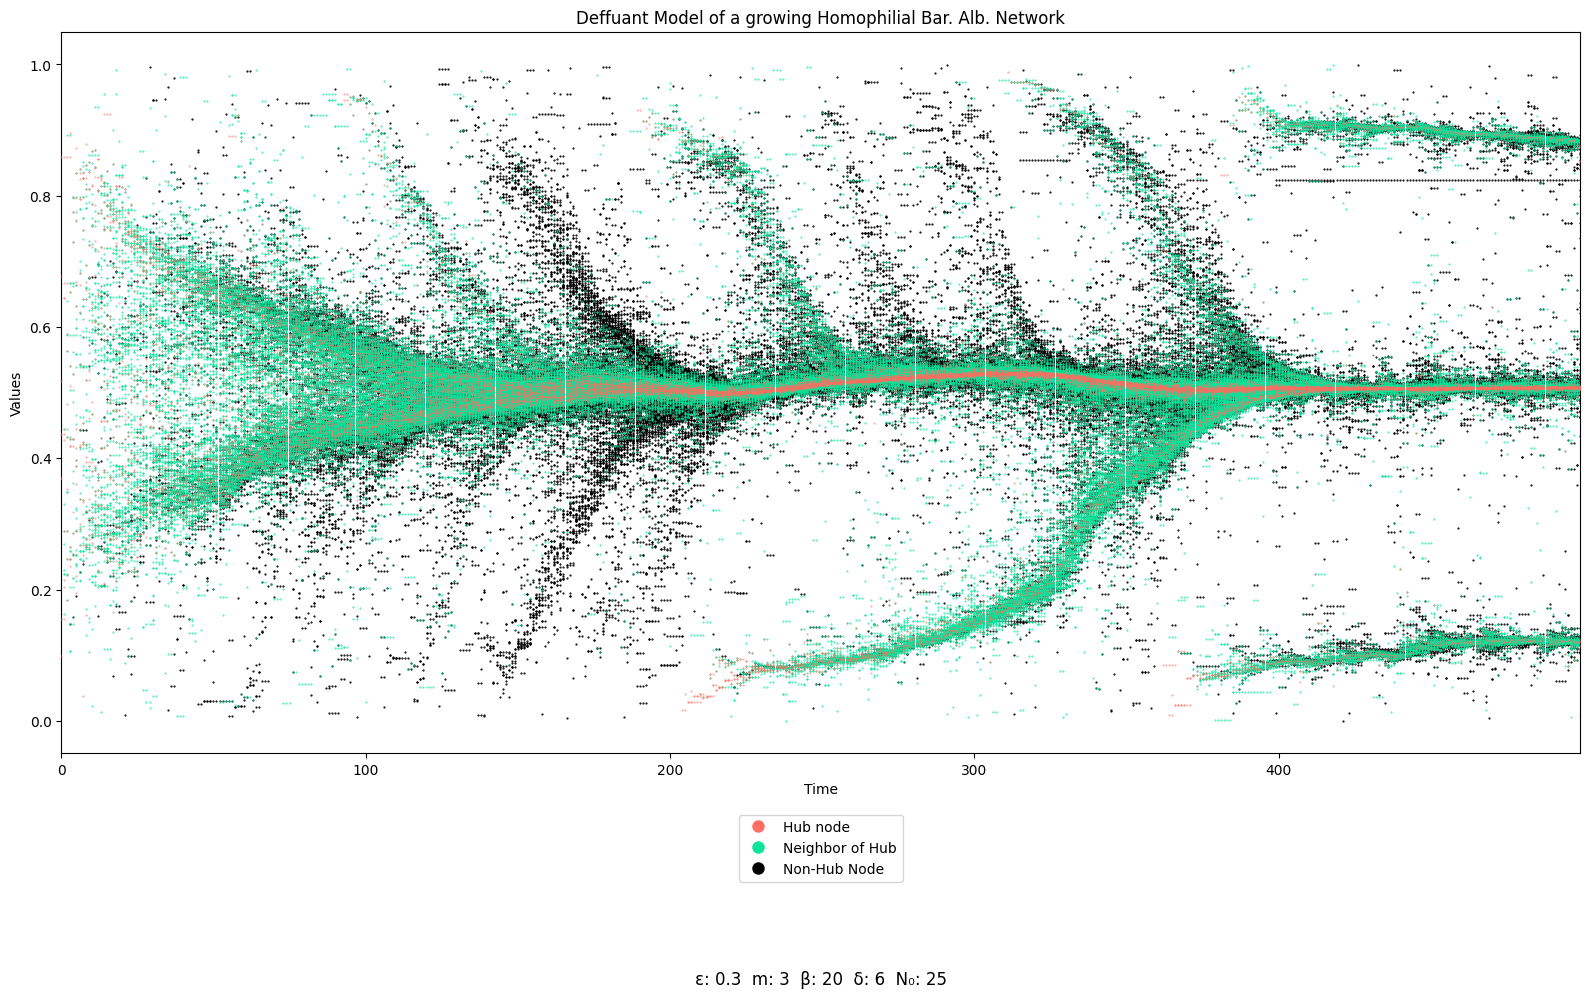

In [ ]:
m = 3
epsilon = 0.3
beta = 20
delta = 6
num_initial_nodes = 25
T = 500
graph = random_fully_connected_graph(5)
model = growing_opinion_dynamics(graph, epsilon, T=T, beta=beta, m=m, delta = delta, num_initial_nodes=num_initial_nodes)

df = pd.DataFrame(model)
plt = deffuant_model_plot_highlight_hubs(graph, df, epsilon, m, beta, delta, num_initial_nodes)
plt.show()

# Community Study simulations
The following code is used to study the communities that are created in our network, as well as performing an analysis on a specific community.

### Community Study 1

In [ ]:
pip install python-louvain

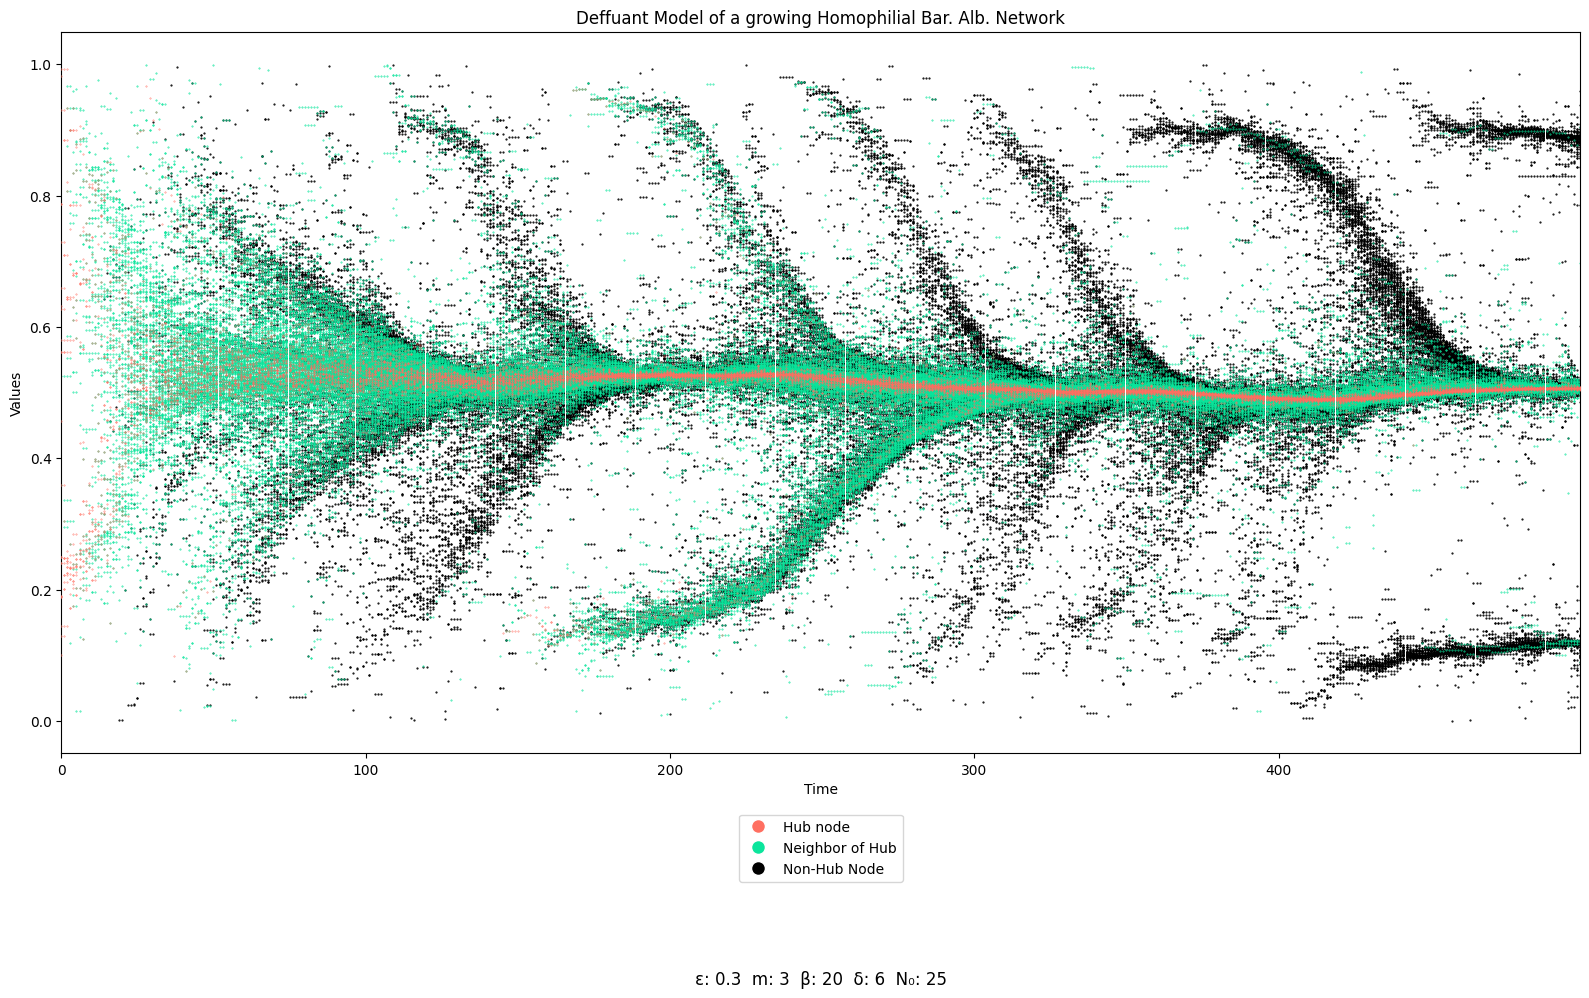

In [ ]:
import pandas as pd
import community.community_louvain as community_louvain
import copy

m = 3
epsilon = 0.3
beta = 20
delta = 6
num_initial_nodes = 25
initial_T = 200
max_T = 500
small_timestep = 10

results = {}

graphs = []
models = []
partitions = []


# Hacemos un time-step de 200 unidades de tiempo, para que el grafo se forme.
graph = random_fully_connected_graph(num_initial_nodes)
model = growing_opinion_dynamics(graph, epsilon, T=initial_T, beta=beta, m=m, delta = 6, num_initial_nodes=num_initial_nodes)

#print(f"The initial model has {len(model)} length (times) for {initial_T} times")


# Guardamos los valores en T = 200
results[initial_T] = {"graph": copy.deepcopy(graph),
                    "partition": community_louvain.best_partition(graph)
                    }


# Empezamos los time-steps pequeños.
for i in range(initial_T, max_T, small_timestep):

    #print(f"Now in time: {i}")

    # Hacemos time-steps pequeños.
    new_model_data = (growing_opinion_dynamics(graph, epsilon, T=small_timestep, beta=beta, m=m, delta = 6, num_initial_nodes=num_initial_nodes))

    #print(f"We have advanced {len(new_model_data)} times")
    model.extend(new_model_data)
    #print(f"The total model has {len(model)} length (times)")

    current_time_dummy = i + small_timestep  # Porque "i" todavia no se ha incrementado pero queremos guardar los resultados siguientes
    results[current_time_dummy] = {
                "graph": copy.deepcopy(graph),
                "partition": community_louvain.best_partition(graph)
                }

    #print(f"Storing results for T = {current_time_dummy} \n")


last_df = pd.DataFrame(model)
last_graph = results[max_T]["graph"]

plt = deffuant_model_plot_highlight_hubs(last_graph, last_df, epsilon, m, beta, delta, num_initial_nodes)
plt.show()

<ipython-input-6-ca0d5e3c124a>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_comunidades)


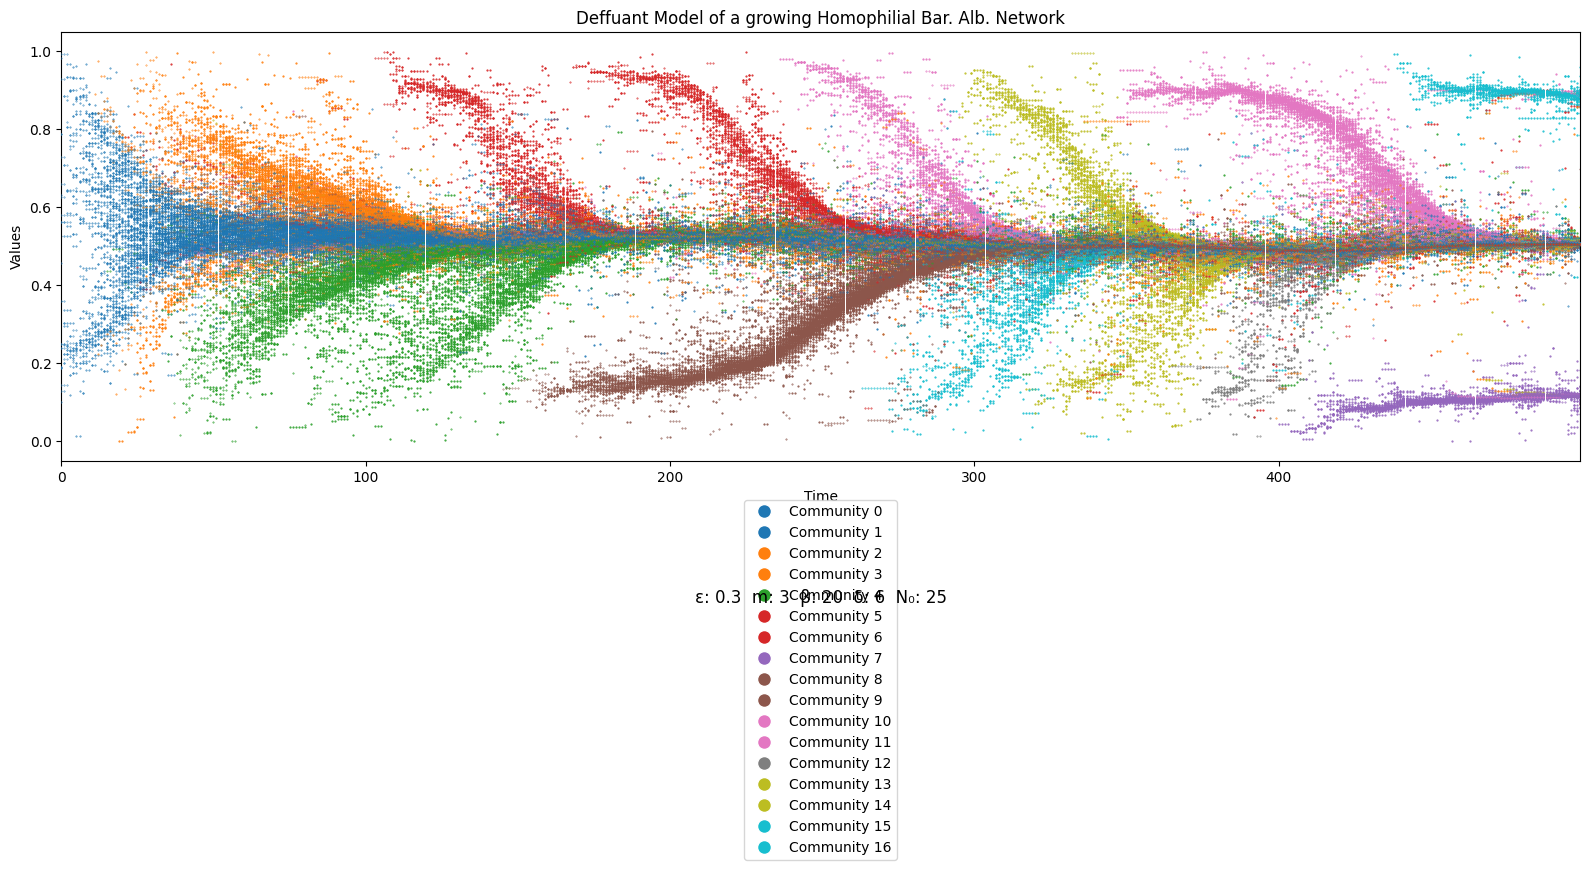

In [ ]:
last_partition = results[max_T]["partition"]

plt = deffuant_model_plot_highlight_communities(last_graph, last_df, epsilon, m, beta, delta, last_partition, num_initial_nodes)
plt.show()

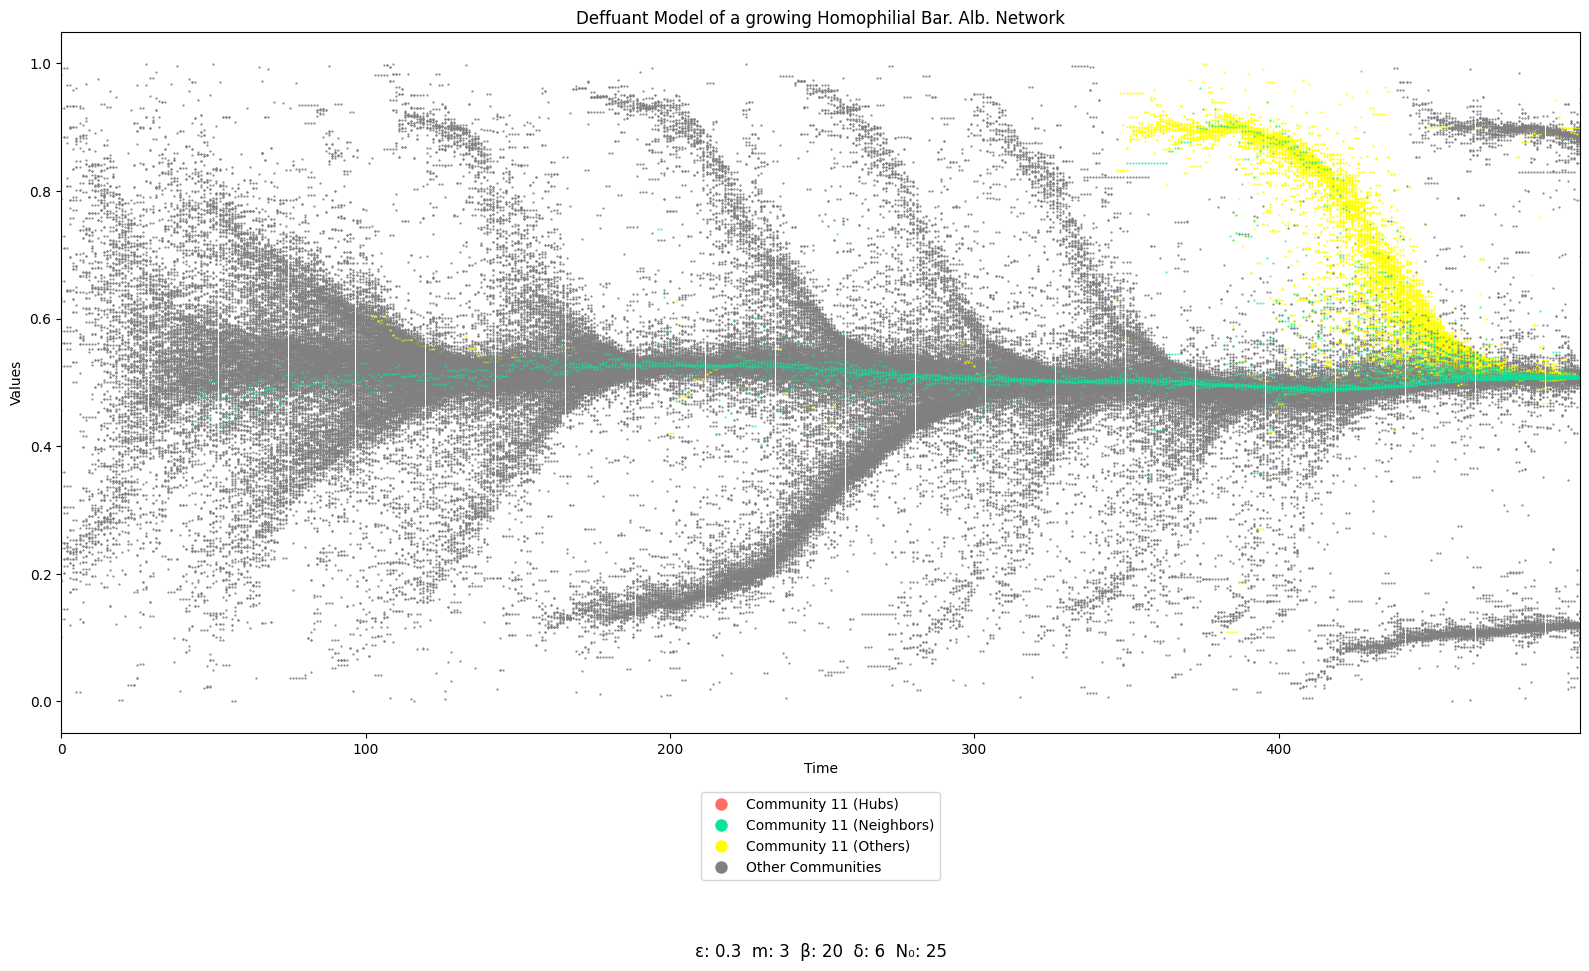

In [ ]:
last_df = pd.DataFrame(model)
last_graph = results[max_T]["graph"]
last_partition = results[max_T]["partition"]

plt = deffuant_model_plot_highlight_single_community(last_graph, last_df, epsilon, m, beta, delta, last_partition, 11, num_initial_nodes)
plt.show()

<ipython-input-6-ca0d5e3c124a>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_comunidades)


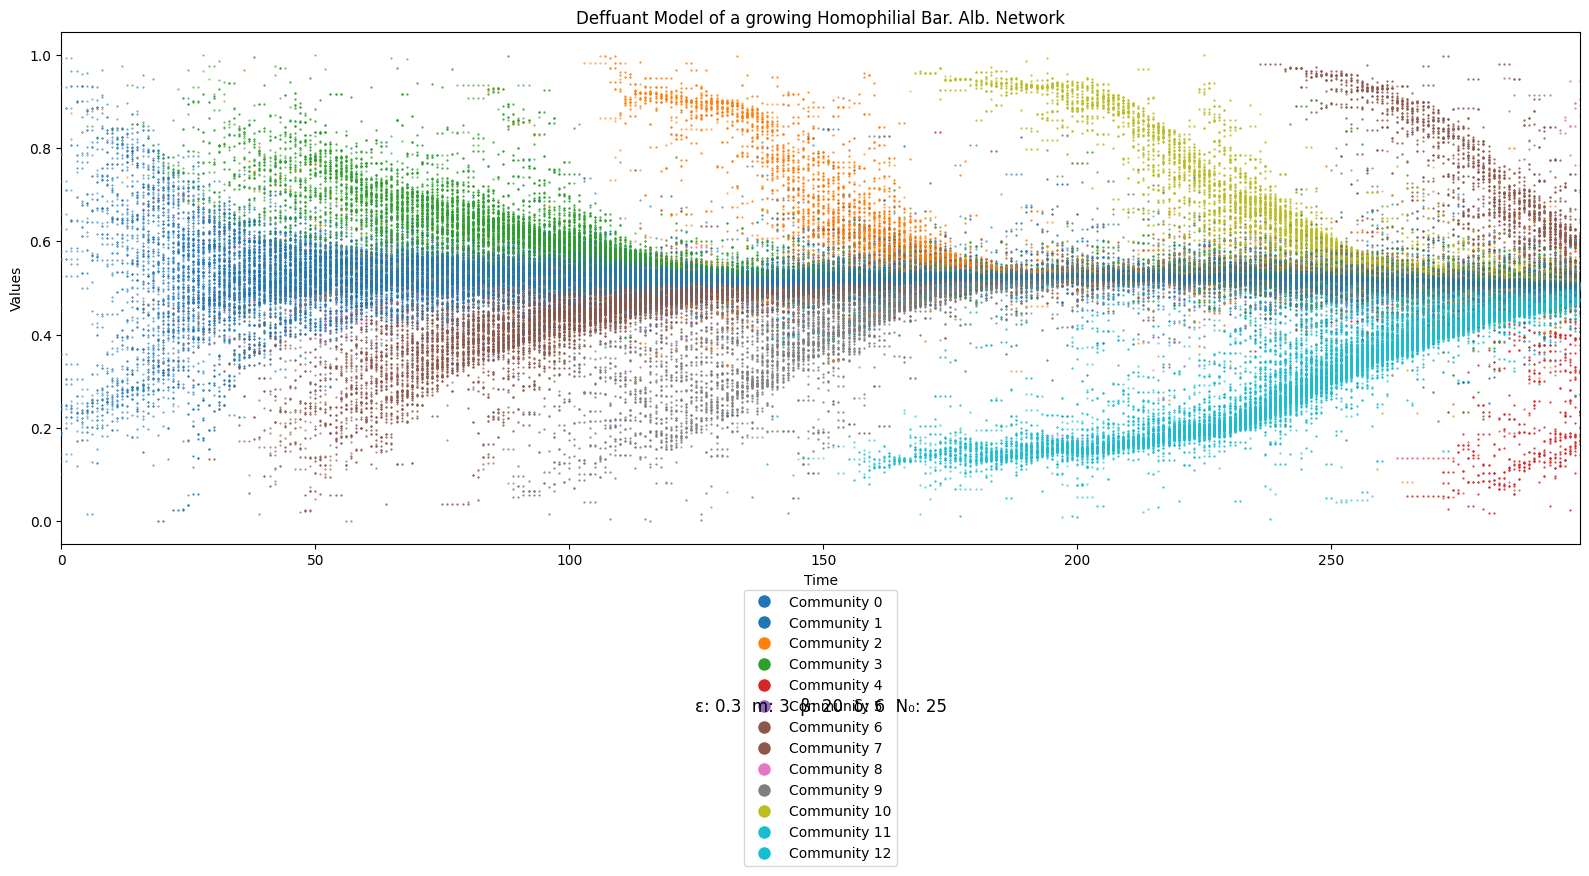

In [ ]:
df_350 = pd.DataFrame(model[:300])
graph_350 = results[300]["graph"]
partition_350 = results[300]["partition"]

plt = deffuant_model_plot_highlight_communities(graph_350, df_350, epsilon, m, beta, delta, partition_350, num_initial_nodes)
plt.show()

#### Chart showing the graph

<ipython-input-70-a90158944e08>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_comunidades)


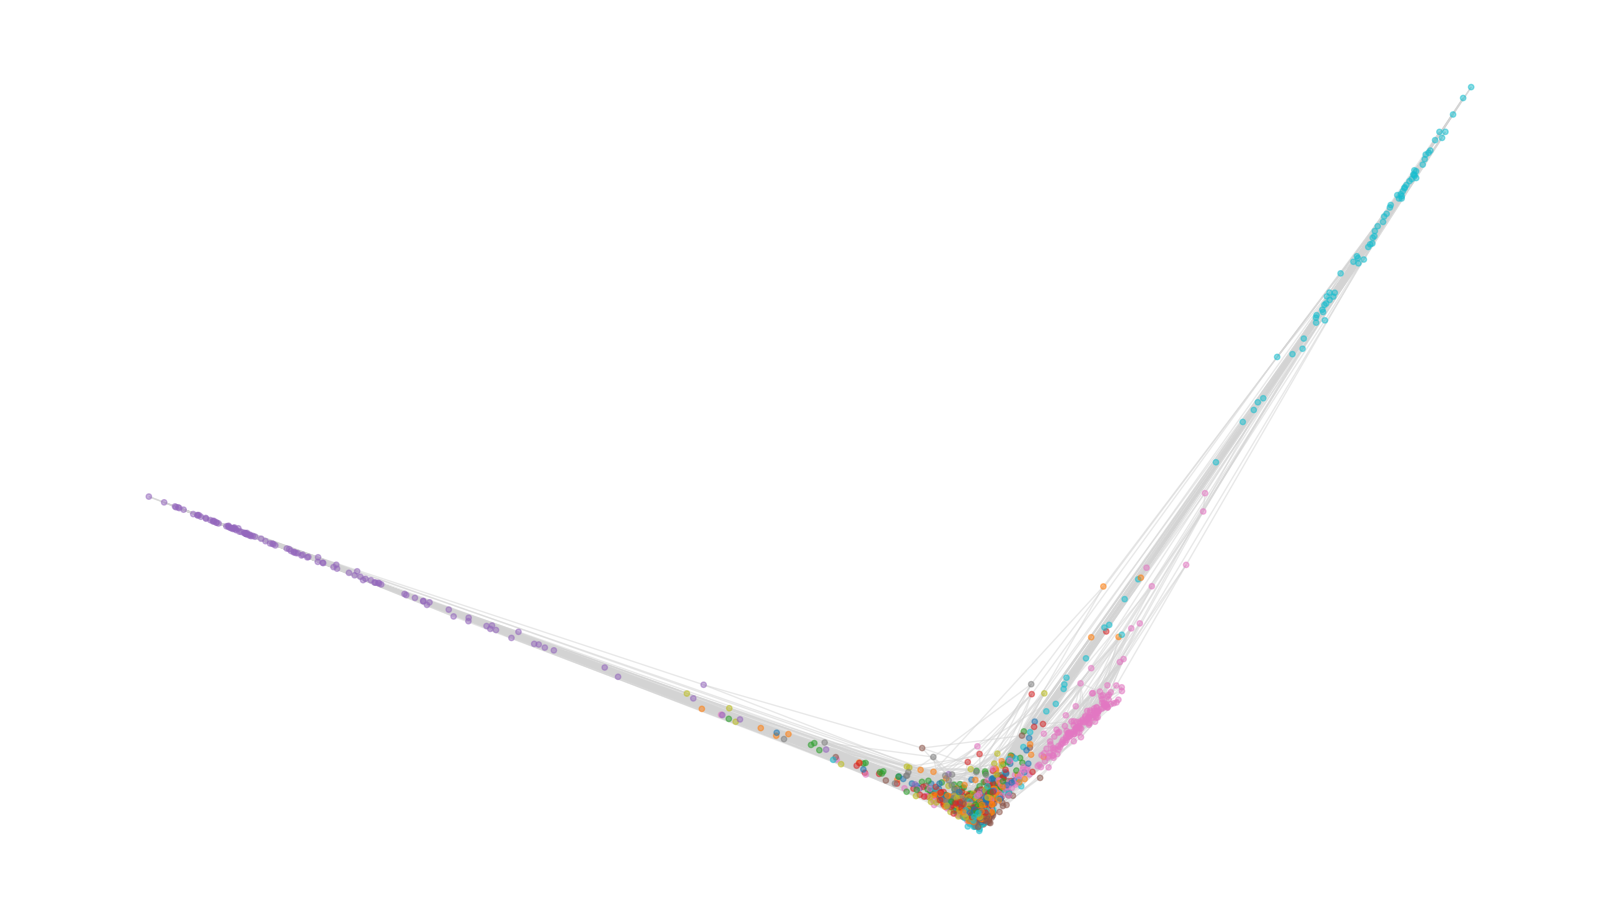

In [ ]:
last_partition = results[max_T]["partition"]
#last_df = pd.DataFrame(model)
last_graph = results[max_T]["graph"]

communities = set(last_partition.values())
colors = [last_partition[node] for node in last_graph.nodes()]

num_comunidades = len(set(last_partition.values()))
colormap = cm.get_cmap('tab10', num_comunidades)
comunidad_colors = {comunidad: colormap(i) for i, comunidad in enumerate(set(last_partition.values()))}

# Obtener colores para cada nodo en el grafo
colors = [comunidad_colors[last_partition[node]] for node in last_graph.nodes()]

# Dibujar el grafo
pos = nx.spectral_layout(last_graph)  # Puedes usar otros layouts si prefieres
plt.figure(figsize=(16, 9))
nx.draw(last_graph, pos, node_color=colors, with_labels=False, cmap=plt.cm.jet, node_size=15, font_size=10,
        edge_color='lightgray', width=1.0, alpha=0.5)
plt.show()

<ipython-input-74-4015046c915a>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_comunidades)


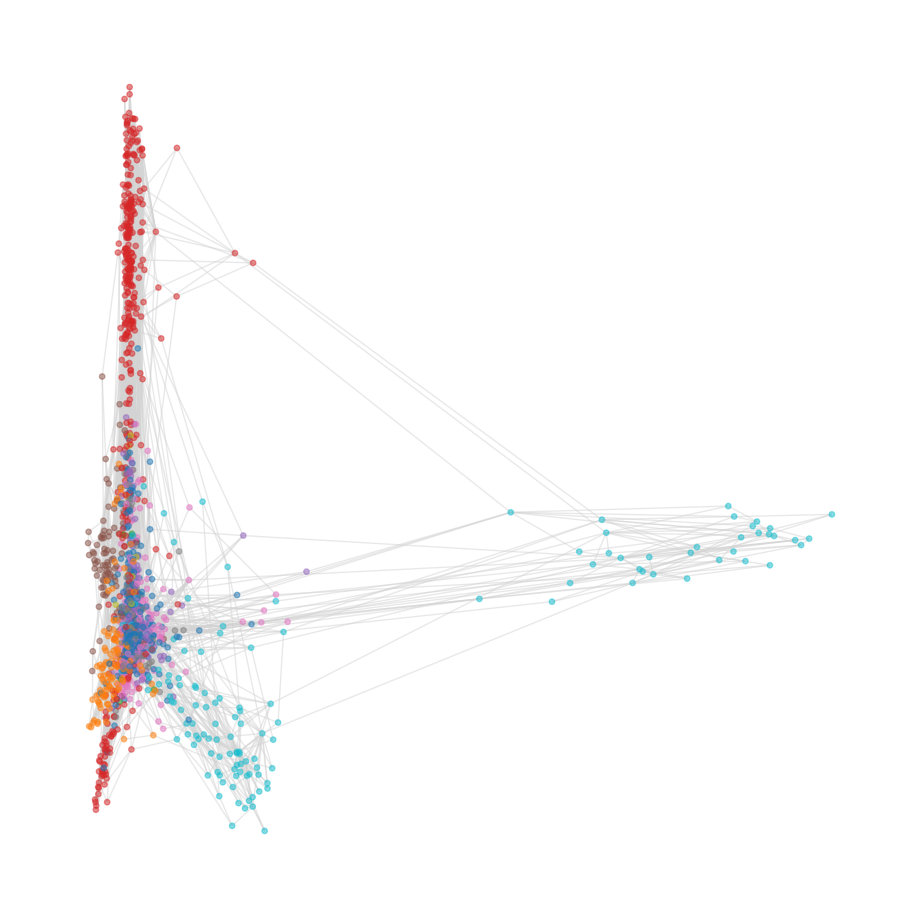

In [ ]:
last_partition = results[380]["partition"]
#last_df = pd.DataFrame(model)
last_graph = results[380]["graph"]

communities = set(last_partition.values())
colors = [last_partition[node] for node in last_graph.nodes()]

num_comunidades = len(set(last_partition.values()))
colormap = cm.get_cmap('tab10', num_comunidades)
comunidad_colors = {comunidad: colormap(i) for i, comunidad in enumerate(set(last_partition.values()))}

# Obtener colores para cada nodo en el grafo
colors = [comunidad_colors[last_partition[node]] for node in last_graph.nodes()]
# Dibujar el grafo
pos = nx.spectral_layout(last_graph)  # Puedes usar otros layouts si prefieres
plt.figure(figsize=(9, 9))
nx.draw(last_graph, pos, node_color=colors, with_labels=False, cmap=plt.cm.jet, node_size=15, font_size=10,
        edge_color='lightgray', width=1.0, alpha=0.5)
plt.show()

<ipython-input-87-6a101716fc26>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_comunidades)


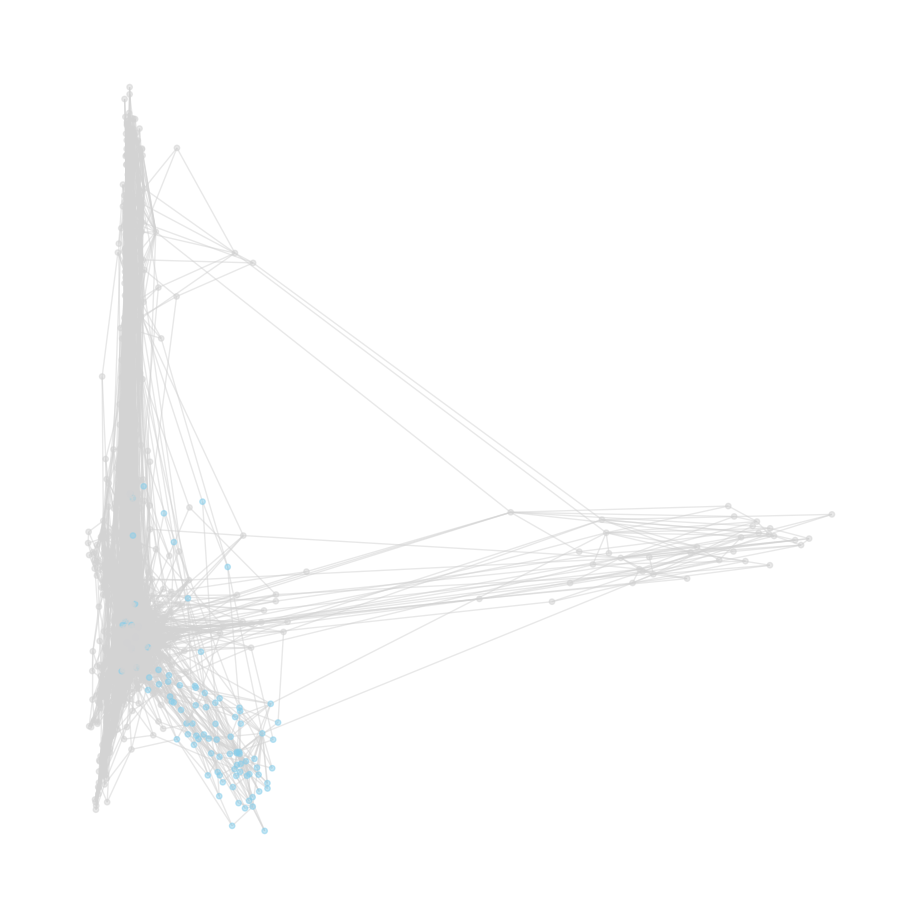

In [ ]:
last_partition = results[380]["partition"]
#last_df = pd.DataFrame(model)
last_graph = results[380]["graph"]

communities = set(last_partition.values())
colors = [last_partition[node] for node in last_graph.nodes()]

num_comunidades = len(set(last_partition.values()))
colormap = cm.get_cmap('tab10', num_comunidades)
# Asignar gris a todas las comunidades
comunidad_colors = {comunidad: 'lightgray' for comunidad in set(partition.values())}

# Cambiar el color de la comunidad 13 a azul cielo
comunidad_colors[13] = 'skyblue'

# Obtener colores para cada nodo en el grafo
colors = [comunidad_colors[partition[node]] for node in G.nodes()]
# Dibujar el grafo
pos = nx.spectral_layout(last_graph)  # Puedes usar otros layouts si prefieres
plt.figure(figsize=(9, 9))
nx.draw(last_graph, pos, node_color=colors, with_labels=False, cmap=plt.cm.jet, node_size=15, font_size=10,
        edge_color='lightgray', width=1.0, alpha=0.5)
plt.show()

<ipython-input-102-3179046bb773>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_comunidades)


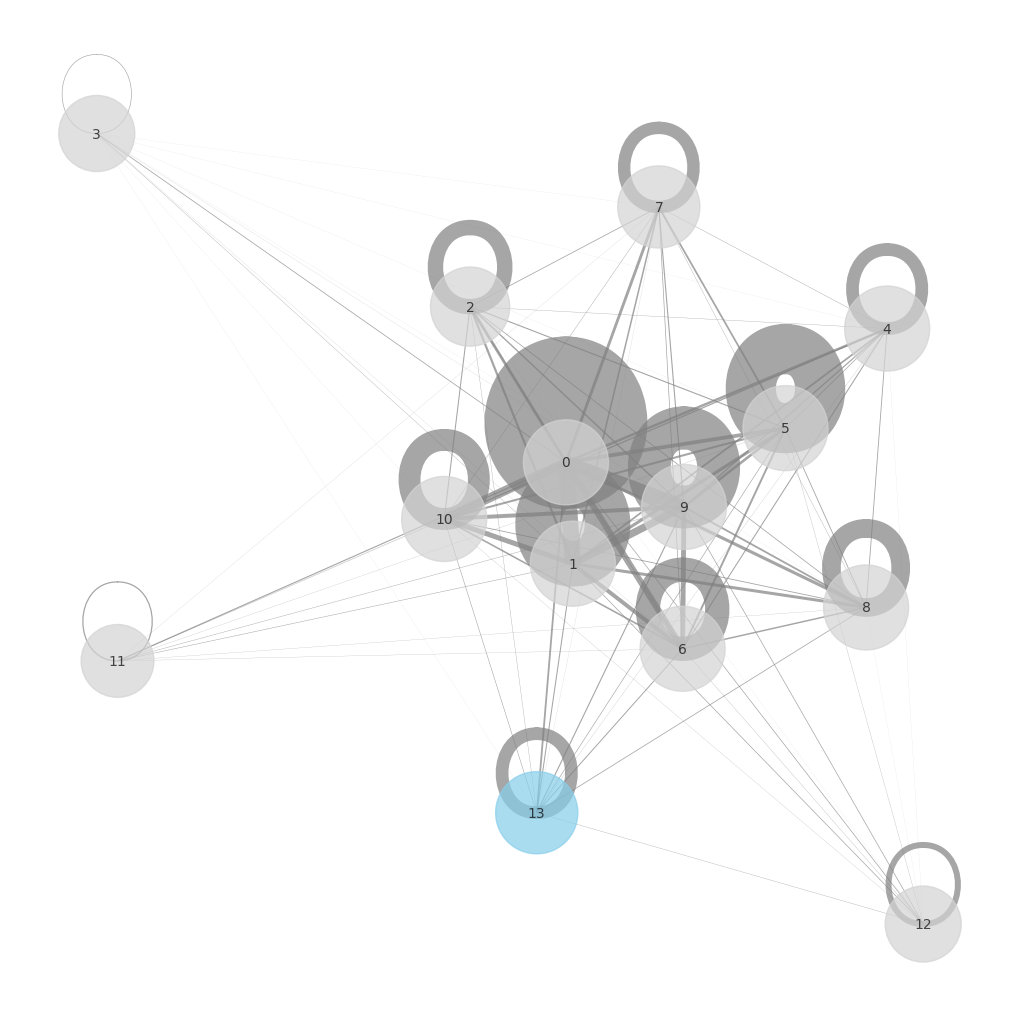

In [ ]:
from community import community_louvain

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

# Suponiendo que last_partition, partition_380, y last_graph ya están definidos en tu entorno
partition = partition_380
G = last_graph

# Definir la paleta de colores
num_comunidades = len(set(partition.values()))
colormap = cm.get_cmap('tab10', num_comunidades)

# Asignar gris a todas las comunidades
comunidad_colors = {comunidad: 'lightgray' for comunidad in set(partition.values())}

# Cambiar el color de la comunidad 13 a azul cielo
comunidad_colors[13] = 'skyblue'

# Obtener colores para cada nodo en el grafo
colors = [comunidad_colors[partition[node]] for node in G.nodes()]

# Crear el grafo de comunidades inducidas
community_graph = community_louvain.induced_graph(partition_380, G)

# Asignar tamaños de nodos y grosor de aristas
node_sizes = [community_graph.degree[comm] * 250 for comm in community_graph.nodes()]
edge_weights = [d['weight'] / 20 for (u, v, d) in community_graph.edges(data=True)]

# Obtener colores para cada comunidad en el grafo de comunidades
community_colors = [comunidad_colors[comm] for comm in community_graph.nodes()]

# Determinar posiciones usando un layout
pos = nx.spring_layout(community_graph)

# Dibujar el grafo de comunidades
plt.figure(figsize=(10, 10))
nx.draw(community_graph, pos, node_size=node_sizes, with_labels=True, font_size=10,
        width=edge_weights, edge_color='gray', node_color=community_colors, alpha=0.7)
plt.show()


#### Community Study

<ipython-input-6-ca0d5e3c124a>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_comunidades)


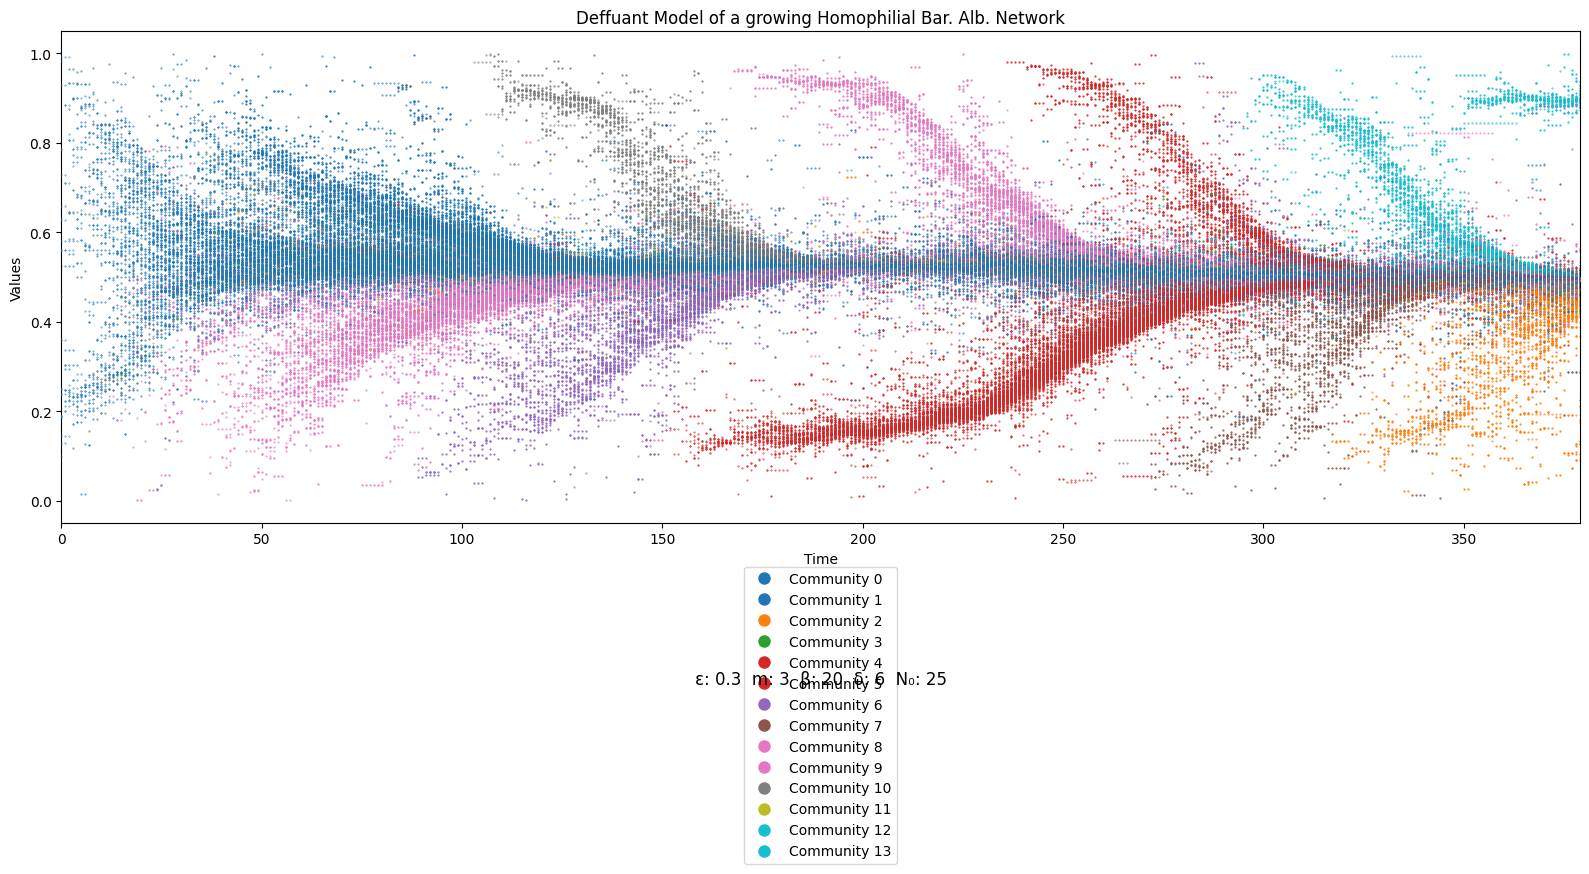

In [ ]:
# Community Study: Graph at T = 380
df_350 = pd.DataFrame(model[:380])
graph_350 = results[380]["graph"]
partition_350 = results[380]["partition"]

plt = deffuant_model_plot_highlight_communities(graph_350, df_350, epsilon, m, beta, delta, partition_350, num_initial_nodes)
plt.show()

370	 percentage_nodes_in_threshold: 0.64 
36


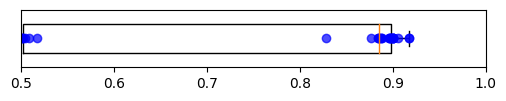

380	 percentage_nodes_in_threshold: 0.73 
49


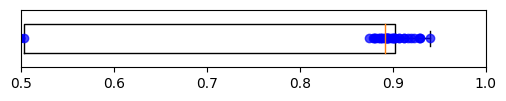

390	 percentage_nodes_in_threshold: 0.73 
66


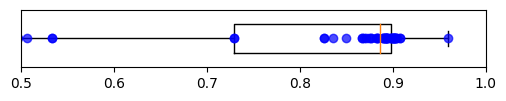

400	 percentage_nodes_in_threshold: 0.72 
88


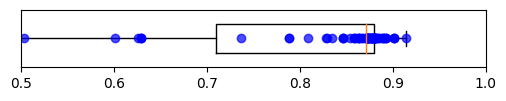

410	 percentage_nodes_in_threshold: 0.69 
106


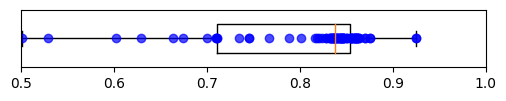

420	 percentage_nodes_in_threshold: 0.61 
120


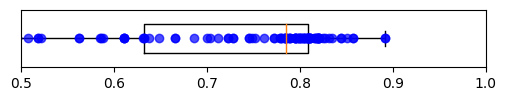

440	 percentage_nodes_in_threshold: 0.79 
164


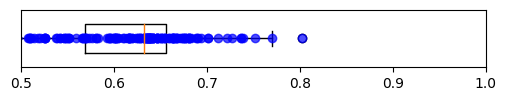

460	 percentage_nodes_in_threshold: 0.99 
174


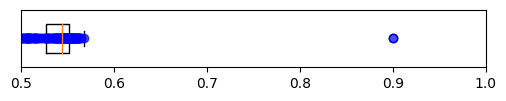

480	 percentage_nodes_in_threshold: 0.99 
180


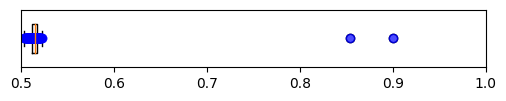

In [ ]:
# Community study: Avg_opinion of nodes in community 11 (T = 380)

last_partition = results[max_T]["partition"]
last_graph = results[max_T]["graph"]

sum_opinions = 0
count_nodes = 0

community_11_nodes = {}

community_to_study = 11

for node, community in last_partition.items():
    if community == community_to_study:
        community_11_nodes[node] = community

timestamps = [370,      380,        390,        400,    410,        420,        440,        460,    480]
thresholds = [[0.8, 1], [0.8, 1], [0.8, 1], [0.8, 1], [0.8, 1], [0.75, 0.9], [0.55, 0.75], [0.50, 0.7], [0.5, 0.6]]
combined_array = list(zip(timestamps, thresholds))

for curr_timestamp, threshold in combined_array:

    sum_opinions = 0
    count_nodes = 0
    nodes_in_threshold = 0
    count_active_inner_links = 0
    count_inactive_inner_links = 0
    count_active_outer_links = 0
    count_inactive_outer_links = 0
    graph = results[curr_timestamp]["graph"]
    curr_opinions = []

    for node, community in community_11_nodes.items():
        if node in graph.nodes:
            sum_opinions += graph.nodes[node]["opinion"]
            count_nodes += 1
            curr_opinions.append(graph.nodes[node]["opinion"])

            if threshold[0] <= graph.nodes[node]["opinion"] <= threshold[1]:
                nodes_in_threshold += 1

            for neighbor in graph.neighbors(node):

                # Calcula la diferencia de opiniones
                opinion_difference = abs(graph.nodes[node]["opinion"] - graph.nodes[neighbor]["opinion"])

                if last_partition[neighbor] == community_to_study:  # inner_link

                    if opinion_difference < epsilon:
                        count_active_inner_links += 1
                    else:
                        count_inactive_inner_links += 1

                else:   # outer_link

                    if opinion_difference < epsilon:
                        count_active_outer_links += 1
                    else:
                        count_inactive_outer_links += 1

    avg_opinion = sum_opinions / count_nodes

    total_links = count_active_inner_links + count_inactive_inner_links + count_active_outer_links + count_inactive_outer_links

    #print(f"""{curr_timestamp}\t active_inner: {(count_active_inner_links * 100 / total_links):.2f}\t inactive_inner: {(count_inactive_inner_links * 100 / total_links):.2f}\t active_outer: {(count_active_outer_links * 100 / total_links):.2f}\t inactive_outer: {(count_inactive_outer_links * 100 / total_links):.2f}""")
    print(f"""{curr_timestamp}\t percentage_nodes_in_threshold: {(nodes_in_threshold / count_nodes):.2f} """)



    print(len(curr_opinions))
    import matplotlib.pyplot as plt
    # Crear el boxplot horizontal y hacer la figura más fina
    plt.figure(figsize=(6, 0.75))  # Ajusta la altura para que sea más fina
    plt.boxplot(curr_opinions, vert=False, widths=0.5)

    # Añadir los puntos individuales de las opiniones
    y = np.ones(len(curr_opinions))  # Todos los puntos en la misma altura
    plt.scatter(curr_opinions, y, color='blue', alpha=0.7, zorder=2)

    # Ajustar el rango del eje X entre 0.5 y 1
    plt.xlim(0.5, 1)

    # Ajustar los ejes para que se vea mejor
    plt.yticks([])

    # Mostrar el gráfico
    plt.show()


### Community Study 2

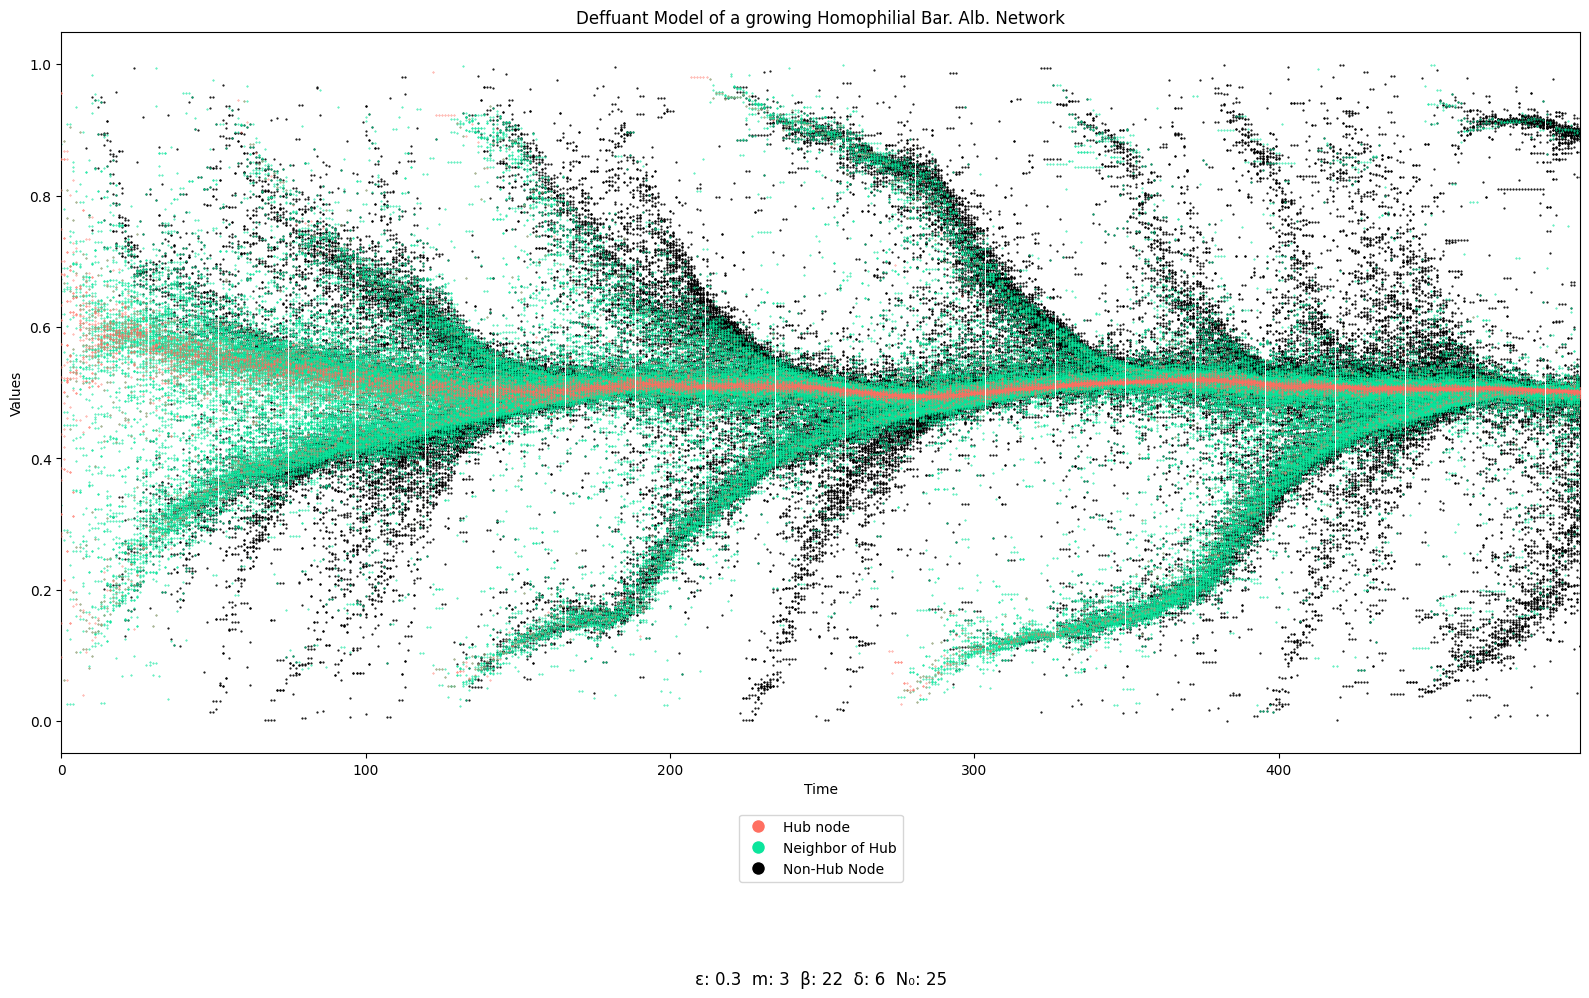

In [ ]:
import pandas as pd
import community.community_louvain as community_louvain
import copy

m = 3
epsilon = 0.3
beta = 22
delta = 6
num_initial_nodes = 25
initial_T = 200
max_T = 500
small_timestep = 10

results = {}

graphs = []
models = []
partitions = []


# Hacemos un time-step de 200 unidades de tiempo, para que el grafo se forme.
graph = random_fully_connected_graph(num_initial_nodes)
model = growing_opinion_dynamics(graph, epsilon, T=initial_T, beta=beta, m=m, delta = 6, num_initial_nodes=num_initial_nodes)

#print(f"The initial model has {len(model)} length (times) for {initial_T} times")


# Guardamos los valores en T = 200
results[initial_T] = {"graph": copy.deepcopy(graph),
                    "partition": community_louvain.best_partition(graph)
                    }


# Empezamos los time-steps pequeños.
for i in range(initial_T, max_T, small_timestep):

    #print(f"Now in time: {i}")

    # Hacemos time-steps pequeños.
    new_model_data = (growing_opinion_dynamics(graph, epsilon, T=small_timestep, beta=beta, m=m, delta = 6, num_initial_nodes=num_initial_nodes))

    #print(f"We have advanced {len(new_model_data)} times")
    model.extend(new_model_data)
    #print(f"The total model has {len(model)} length (times)")

    current_time_dummy = i + small_timestep  # Porque "i" todavia no se ha incrementado pero queremos guardar los resultados siguientes
    results[current_time_dummy] = {
                "graph": copy.deepcopy(graph),
                "partition": community_louvain.best_partition(graph)
                }

    #print(f"Storing results for T = {current_time_dummy} \n")


last_df = pd.DataFrame(model)
last_graph = results[max_T]["graph"]

plt = deffuant_model_plot_highlight_hubs(last_graph, last_df, epsilon, m, beta, delta, num_initial_nodes)
plt.show()

Community detection at max_T (T = 500)

<ipython-input-8-ca0d5e3c124a>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_comunidades)


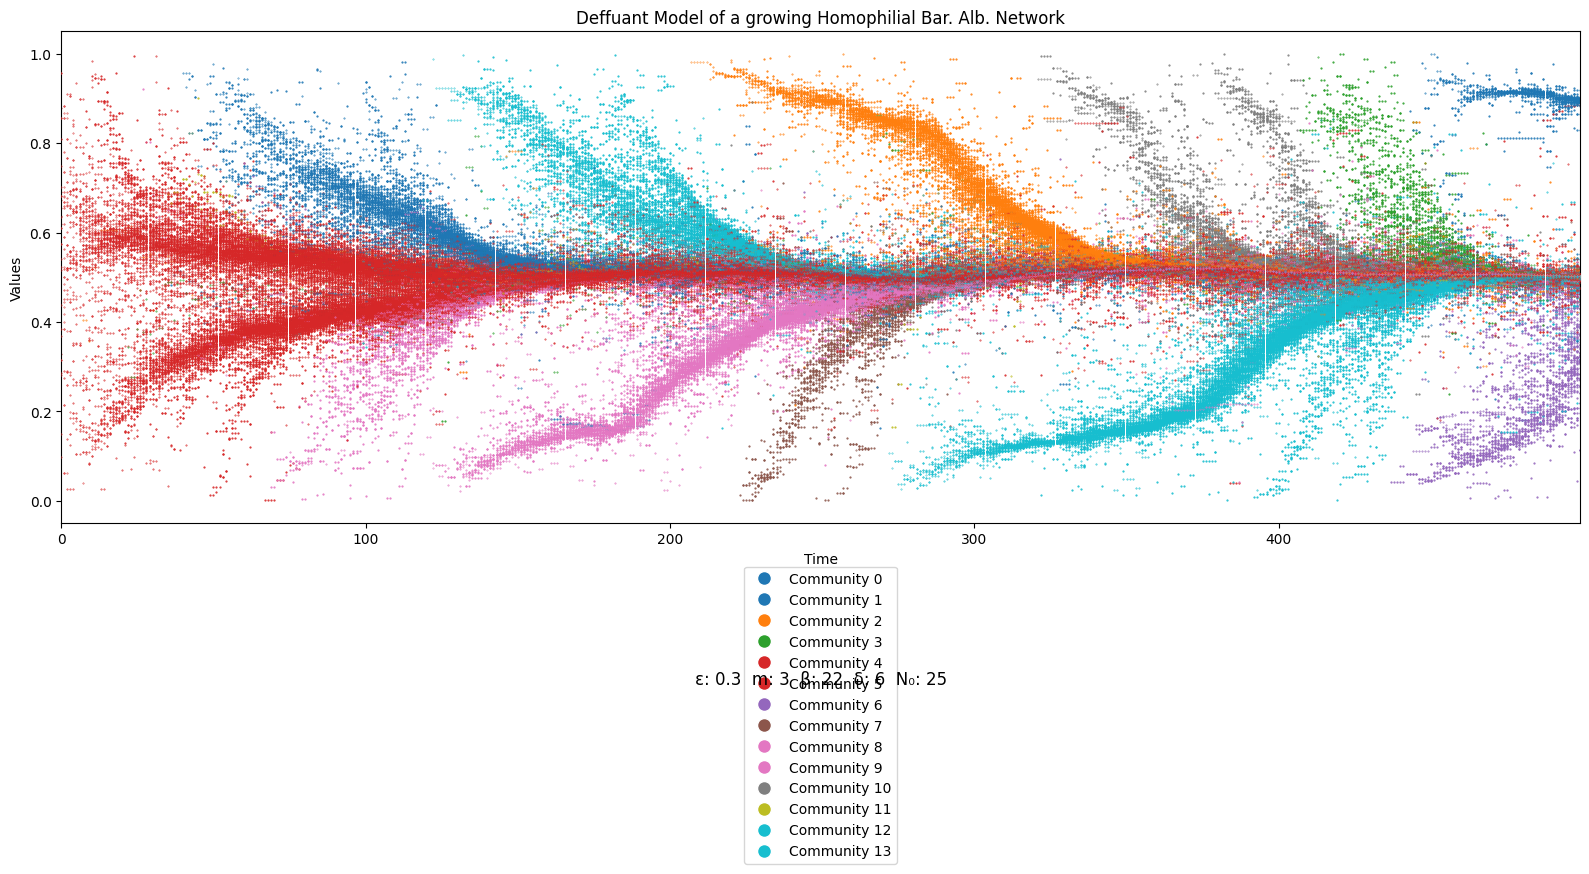

In [ ]:
last_partition = results[max_T]["partition"]

plt = deffuant_model_plot_highlight_communities(last_graph, last_df, epsilon, m, beta, delta, last_partition, num_initial_nodes)
plt.show()

Hihglight the community we want to study

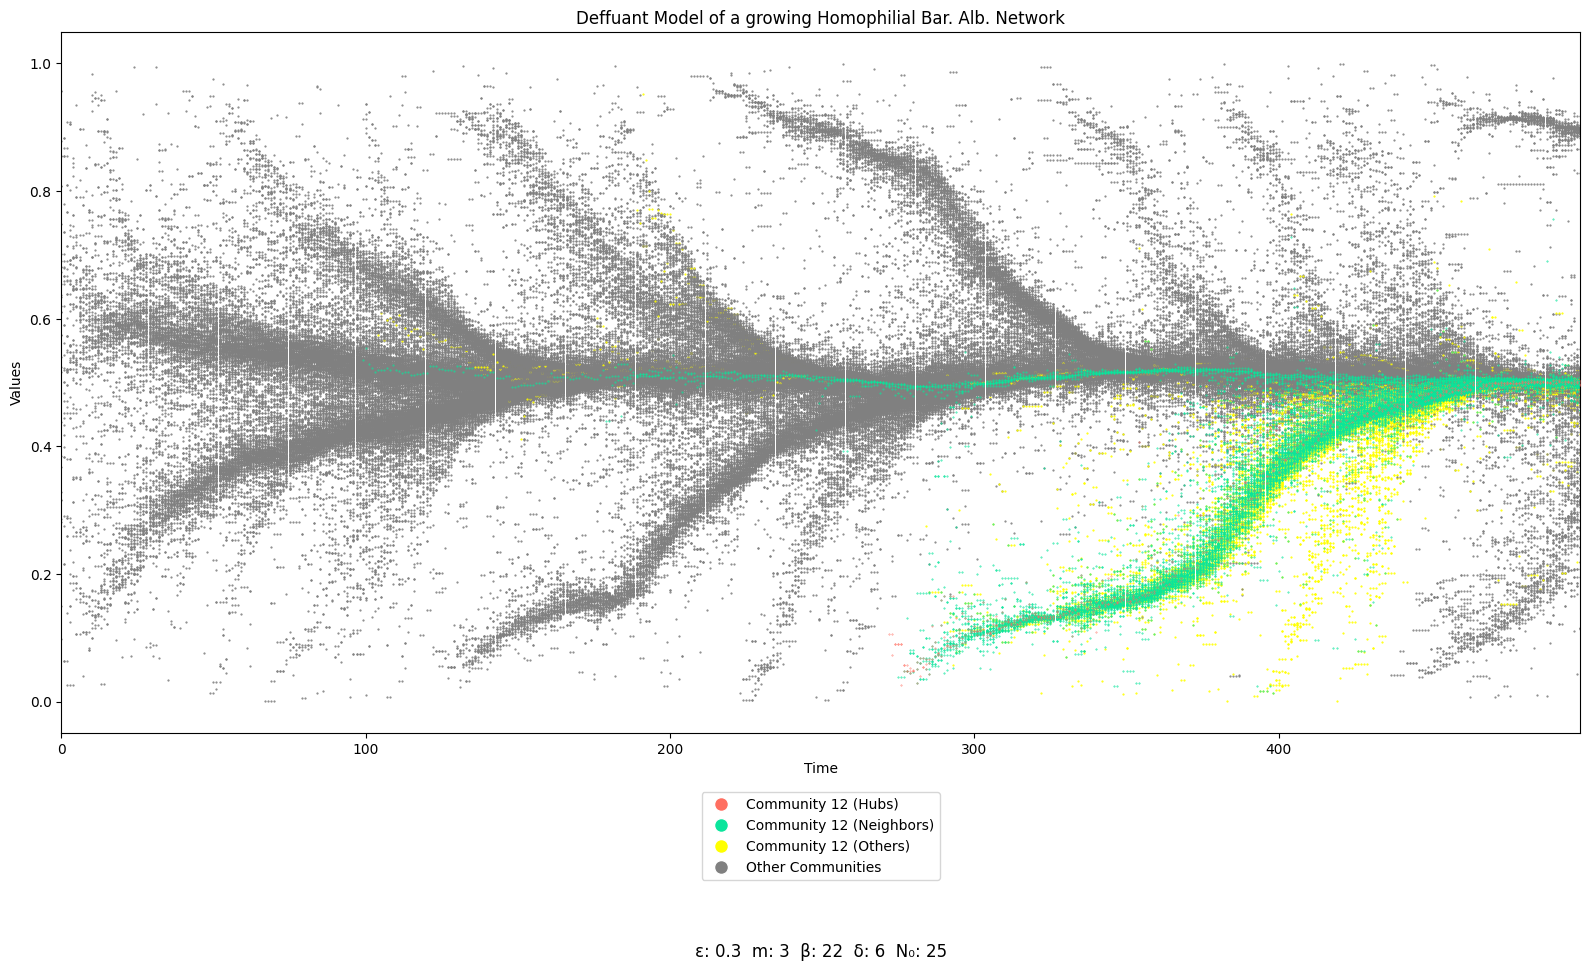

In [ ]:
last_df = pd.DataFrame(model)
last_graph = results[max_T]["graph"]
last_partition = results[max_T]["partition"]
community_to_highlight = 12
plt = deffuant_model_plot_highlight_single_community(last_graph, last_df, epsilon, m, beta, delta, last_partition, community_to_highlight, num_initial_nodes)
plt.show()

Obtaining community metrics and boxplots for different T values

<ipython-input-48-6dde7f901b02>:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
<ipython-input-48-6dde7f901b02>:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
<ipython-input-48-6dde7f901b02>:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
<ipython-input-48-6dde7f901b02>:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two 

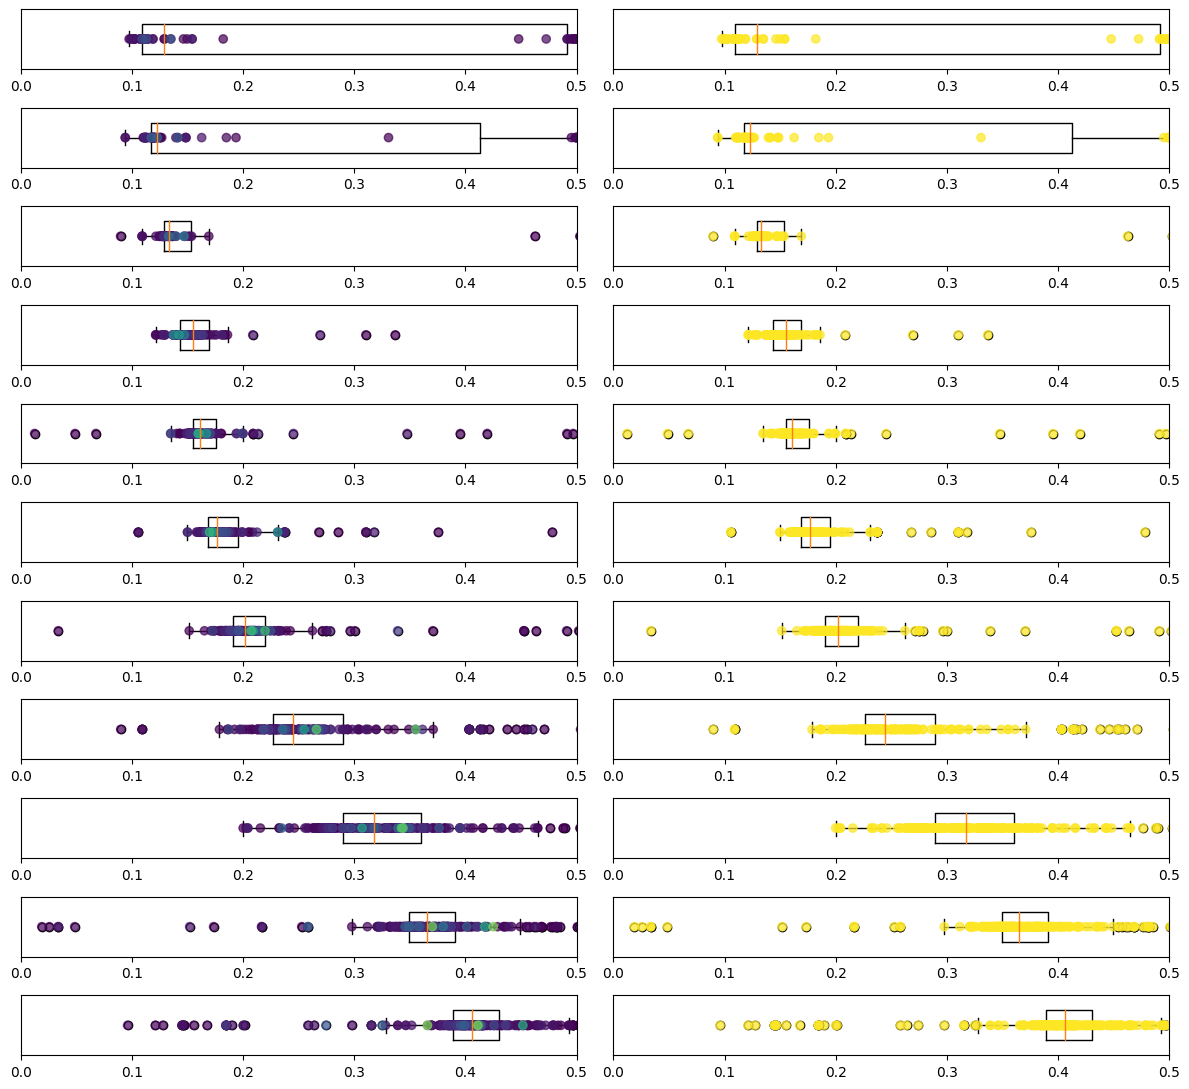

<ipython-input-48-6dde7f901b02>:126: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, orientation="horizontal", pad=0.3, aspect=50)


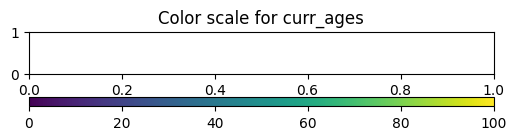

timestamp  nodes_in_comm avg_opinion active_inner inactive_inner  \
0         300             46         0.2         72.6            1.8   
1         310             59         0.2         77.2            1.3   
2         320             74         0.2         80.2            1.6   
3         340            116         0.2         85.3            1.0   
4         350            138         0.2         85.9            1.3   
5         360            160         0.2         87.0            1.1   
6         370            184         0.2         88.5            1.2   
7         380            204         0.3         89.8            0.2   
8         390            226         0.3         89.9            0.0   
9         400            255         0.4         89.8            0.4   
10        410            277         0.4         89.7            0.1   

   active_outer inactive_outer  
0          18.1            7.5  
1          14.4            7.0  
2          12.0            6.2  
3           7.9            5.9  
4           7.6            5.2  
5           7.8            4.0  
6           7.2            3.1  
7           9.6            0.4  
8          10.0            0.1  
9           9.7            0.1  
10         10.0            0.2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
from pandas.plotting import table

# Variables y configuración inicial
community_to_study = 12
timestamps = [300, 310, 320, 340, 350, 360, 370, 380, 390, 400, 410] # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

last_partition = results[max_T]["partition"]
last_graph = results[max_T]["graph"]
export_table = {
    'timestamp': [],
    'nodes_in_comm': [],
    'avg_opinion': [],
    'active_inner': [],
    'inactive_inner': [],
    'active_outer': [],
    'inactive_outer': []
}

# Determinar los nodos pertenecientes a la comunidad de interés
community_nodes = {node: community for node, community in last_partition.items() if community == community_to_study}

# Crear una figura para los subplots
fig, axes = plt.subplots(nrows=len(timestamps), ncols=2, figsize=(12, 1 * len(timestamps)))

for idx, curr_timestamp in enumerate(timestamps):
    sum_opinions = 0
    count_nodes = 0
    count_active_inner_links = 0
    count_inactive_inner_links = 0
    count_active_outer_links = 0
    count_inactive_outer_links = 0
    graph = results[curr_timestamp]["graph"]
    curr_opinions = []
    curr_degrees = []
    curr_ages = []

    # Recolectar datos de los nodos de la comunidad
    for node, community in community_nodes.items():
        if node in graph.nodes:
            sum_opinions += graph.nodes[node]["opinion"]
            count_nodes += 1
            curr_opinions.append(graph.nodes[node]["opinion"])
            curr_degrees.append(graph.degree(node))
            curr_ages.append(graph.nodes[node]["spawn_time"])

            for neighbor in graph.neighbors(node):
                opinion_difference = abs(graph.nodes[node]["opinion"] - graph.nodes[neighbor]["opinion"])
                if last_partition[neighbor] == community_to_study:  # inner_link
                    if opinion_difference < epsilon:
                        count_active_inner_links += 1
                    else:
                        count_inactive_inner_links += 1
                else:  # outer_link
                    if opinion_difference < epsilon:
                        count_active_outer_links += 1
                    else:
                        count_inactive_outer_links += 1

    avg_opinion = sum_opinions / count_nodes
    total_links = (count_active_inner_links + count_inactive_inner_links +
                   count_active_outer_links + count_inactive_outer_links)

    new_row = {
        'timestamp': curr_timestamp,
        'nodes_in_comm': len(curr_opinions),
        'avg_opinion': "{:.1f}".format(avg_opinion),
        'active_inner': "{:.1f}".format(count_active_inner_links * 100 / total_links),
        'inactive_inner': "{:.1f}".format(count_inactive_inner_links * 100 / total_links),
        'active_outer': "{:.1f}".format(count_active_outer_links * 100 / total_links),
        'inactive_outer': "{:.1f}".format(count_inactive_outer_links * 100 / total_links)
    }

    for key in new_row:
        export_table[key].append(new_row[key])

    # Normalizar y preparar datos para graficar
    curr_degrees = np.array(curr_degrees)
    curr_opinions = np.array(curr_opinions)
    curr_ages = np.array(curr_ages)
    norm_degrees = mcolors.Normalize(vmin=3, vmax=60)
    norm_ages = mcolors.Normalize(vmin=0, vmax=100)
    cmap = cm.get_cmap('viridis')

    # Gráfico 1: Basado en grados
    ax1 = axes[idx, 0]
    ax1.boxplot(curr_opinions, vert=False, widths=0.5)
    sizes = 50 * (curr_degrees / 60)
    sorted_indices_degrees = np.argsort(curr_degrees)
    curr_opinions_degrees = curr_opinions[sorted_indices_degrees]
    sizes_degrees = sizes[sorted_indices_degrees]
    colors_degrees = cmap(norm_degrees(curr_degrees[sorted_indices_degrees]))
    y_degrees = np.ones(len(curr_opinions_degrees))
    ax1.scatter(curr_opinions_degrees, y_degrees, color=colors_degrees, alpha=0.7, zorder=2)
    ax1.set_xlim(0, 0.5)
    ax1.set_yticks([])

    # Gráfico 2: Basado en tiempo transcurrido
    ax2 = axes[idx, 1]
    time_diff = curr_timestamp - curr_ages
    color_values_clipped = np.clip(time_diff, 0, 100)
    sorted_indices_time = np.argsort(-time_diff)
    curr_opinions_time = curr_opinions[sorted_indices_time]
    sizes_time = sizes[sorted_indices_time]
    colors_time = cmap(norm_ages(color_values_clipped[sorted_indices_time]))
    y_time = np.ones(len(curr_opinions_time))
    ax2.boxplot(curr_opinions, vert=False, widths=0.5)
    ax2.scatter(curr_opinions_time, y_time, color=colors_time, alpha=0.7, zorder=2)
    ax2.set_xlim(0, 0.5)
    ax2.set_yticks([])

# Ajustar el diseño de los subplots
plt.tight_layout()

# Mostrar la figura con subplots
plt.show()

# Crear una nueva figura para la barra de color
plt.figure(figsize=(6, 1))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_ages)
sm.set_array([])
plt.colorbar(sm, orientation="horizontal", pad=0.3, aspect=50)
plt.title('Color scale for curr_ages')
plt.show()

# Exportar tabla a DataFrame y mostrar
export_df = pd.DataFrame(export_table)
display(export_df)


### Test: Cut off inactive links before detecting communities

<ipython-input-6-ca0d5e3c124a>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_comunidades)


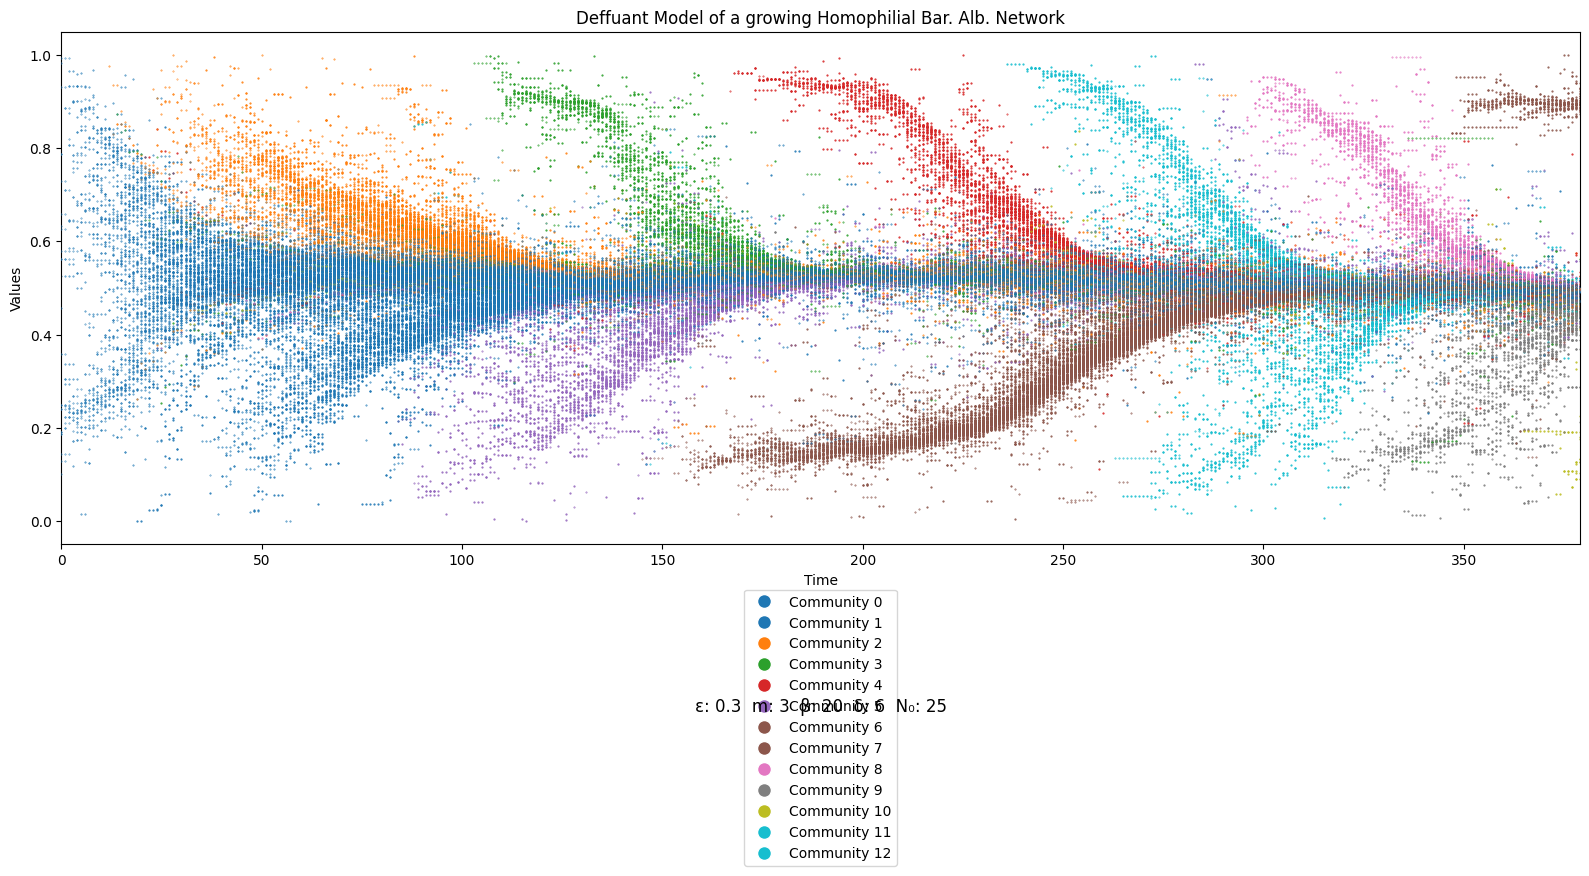

In [ ]:
# Community Study Test: Cut off inactive links and then detect communities
graph_380 = copy.deepcopy(results[380]["graph"])
df_380 = pd.DataFrame(model[:380])

# Crea una lista de aristas a eliminar
edges_to_remove = [
    (u, v) for u, v in graph_380.edges()
    if abs(graph_380.nodes[u]["opinion"] - graph_380.nodes[v]["opinion"]) > epsilon
]

# Elimina las aristas del grafo
graph_380.remove_edges_from(edges_to_remove)

partitions = community_louvain.best_partition(graph_380)

plt = deffuant_model_plot_highlight_communities(graph_380, df_350, epsilon, m, beta, delta, partitions, num_initial_nodes)
plt.show()

# Obtaining logarithmic histogram of node degrees
Used for proof that our networks follow the BA power degree distribution.

<ipython-input-22-e28955a2c6c7>:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(final_log_bin_centers, slope * final_log_bin_centers + intercept, 'r-', linestyle='dashed', label=f'Fit line. Slope: {slope:.2f}')


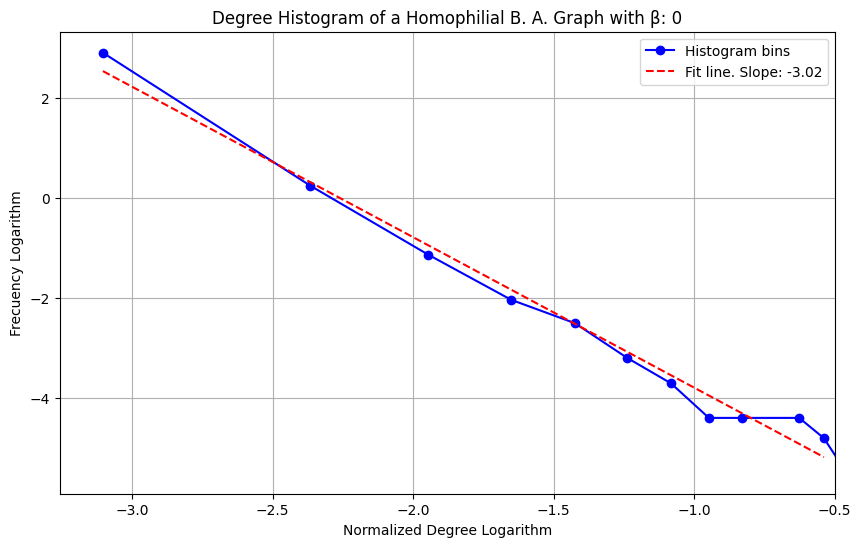

In [ ]:
m = 4
threshold = 0.25
beta = 0

n = 5000

graphs = []

for i in range (0, 20):
    graph = random_fully_connected_graph(5)
    for i in range (0, n):
        grow_homophilial_barabasi_albert_graph(graph, beta, m)
    graphs.append(graph)

plot_degree_distribution_loglog(graphs, beta)

<ipython-input-22-e28955a2c6c7>:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(final_log_bin_centers, slope * final_log_bin_centers + intercept, 'r-', linestyle='dashed', label=f'Fit line. Slope: {slope:.2f}')


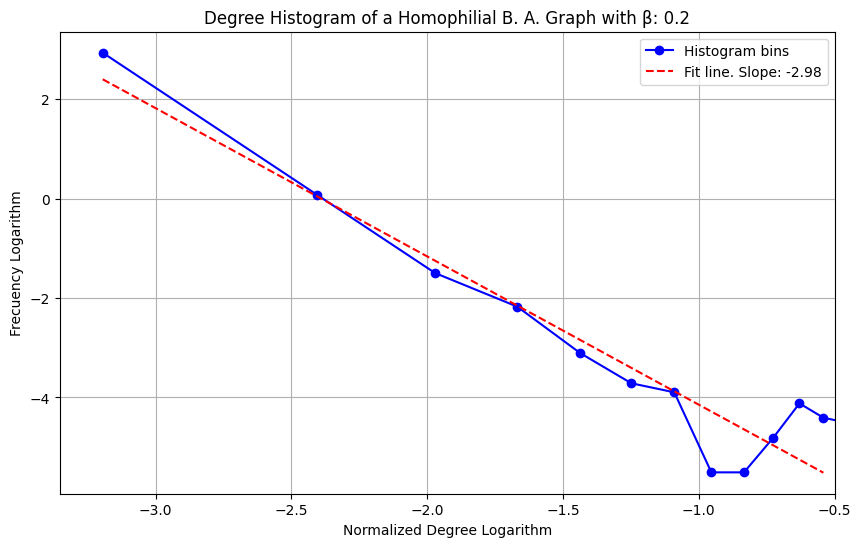

In [ ]:
m = 4
threshold = 0.25
beta = 0.2

n = 5000

graphs = []

for i in range (0, 20):
    graph = random_fully_connected_graph(5)
    for i in range (0, n):
        grow_homophilial_barabasi_albert_graph(graph, beta, m)
    graphs.append(graph)

plot_degree_distribution_loglog(graphs, beta)

<ipython-input-22-e28955a2c6c7>:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(final_log_bin_centers, slope * final_log_bin_centers + intercept, 'r-', linestyle='dashed', label=f'Fit line. Slope: {slope:.2f}')


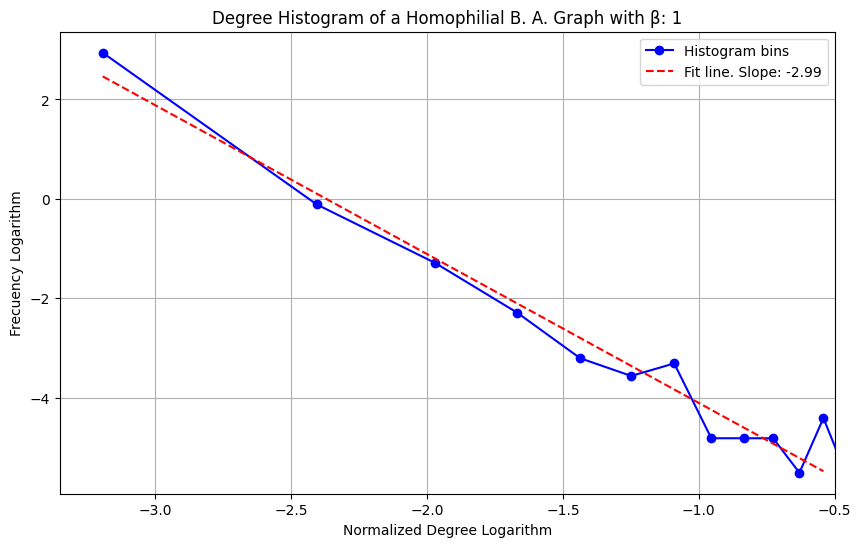

In [ ]:
m = 4
threshold = 0.25
beta = 1

n = 5000

graphs = []

for i in range (0, 20):
    graph = random_fully_connected_graph(5)
    for i in range (0, n):
        grow_homophilial_barabasi_albert_graph(graph, beta, m)
    graphs.append(graph)

plot_degree_distribution_loglog(graphs, beta)

<ipython-input-22-e28955a2c6c7>:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(final_log_bin_centers, slope * final_log_bin_centers + intercept, 'r-', linestyle='dashed', label=f'Fit line. Slope: {slope:.2f}')


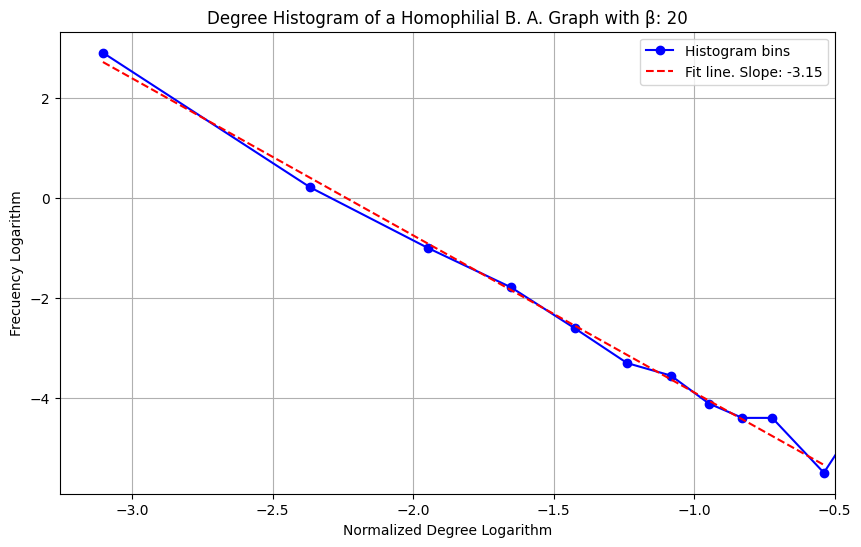

In [ ]:
m = 4
threshold = 0.25
beta = 20

n = 5000

graphs = []

for i in range (0, 20):
    graph = random_fully_connected_graph(5)
    for i in range (0, n):
        grow_homophilial_barabasi_albert_graph(graph, beta, m)
    graphs.append(graph)

plot_degree_distribution_loglog(graphs, beta)

<ipython-input-22-e28955a2c6c7>:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(final_log_bin_centers, slope * final_log_bin_centers + intercept, 'r-', linestyle='dashed', label=f'Fit line. Slope: {slope:.2f}')


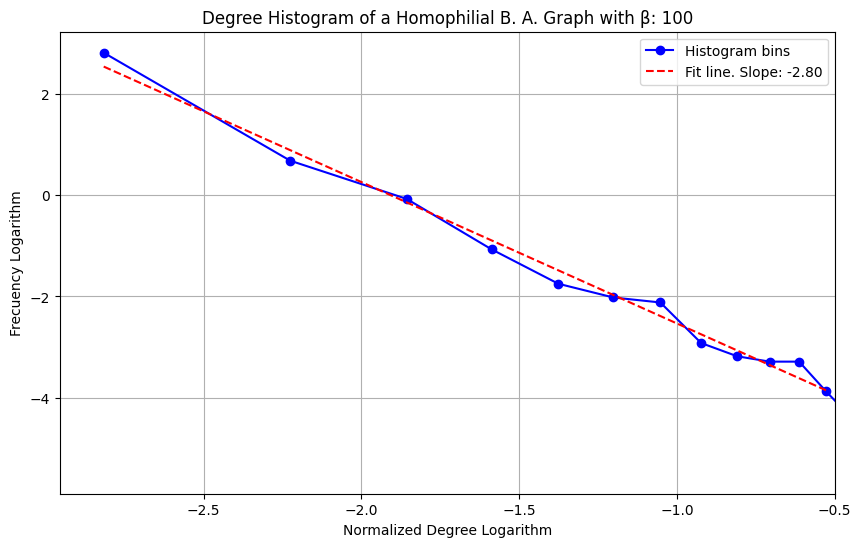

In [ ]:
m = 4
threshold = 0.25
beta = 100

n = 5000

graphs = []

for i in range (0, 20):
    graph = random_fully_connected_graph(5)
    for i in range (0, n):
        grow_homophilial_barabasi_albert_graph(graph, beta, m)
    graphs.append(graph)

plot_degree_distribution_loglog(graphs, beta)